## Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)
sys.modules['dostools.src'] = dostools

In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950166


## Evaluator

In [3]:
import dostools.evaluation.evaluation as evaluation
importlib.reload(evaluation)
import dostools.models.training as training
importlib.reload(training)

targets = {
    'pw' : ldos,
    'lcdf' : y_lcdf,
    'pc' : y_pc
}
evaluator = evaluation.Evaluator(targets, xdos, mean_dos_per_atom)

## Dataset and DataLoader

In [10]:
import dostools.datasets.dataset as data
from torch.utils.data import TensorDataset, DataLoader
import dostools.consistency.consistency as consistency

device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}
#Dataset
y_shifted = copy.deepcopy(y_pw)
#y_shifted[train_index][:100] = consistency.shifted_ldos(y_shifted[:100], xdos, torch.zeros(100)-10)
train_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][train_index[:1]].double(), y_shifted[train_index[:1]].double())
train_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][train_index[:1]].double(), y_shifted[train_index[:1]].double())

test_data_soap = TensorDataset(Silicon.Features["structure_avedescriptors"][test_index].double(), y_shifted[test_index].double())
test_data_kernel = TensorDataset(Silicon.Features["structure_avekerneldescriptors"][test_index].double(), y_shifted[test_index].double())

#Dataloader

train_dataloader_soap = DataLoader(train_data_soap, batch_size = 4, shuffle = True, **kwargs)
train_dataloader_kernel = DataLoader(train_data_kernel, batch_size = 4, shuffle = True, **kwargs)



## Loss Function

In [6]:
import dostools.src.consistency.consistency as consistency
import dostools.src.loss.loss as loss
importlib.reload(loss)
importlib.reload(consistency)

def t_get_BF_shift_index_mse(prediction, true, shift_range, xdos = None, perc = False):
    if xdos is not None:
        mse = torch.zeros(true.shape[0])
        index = torch.zeros(true.shape[0])
        for i, pred in enumerate((prediction)):
            shifted_preds = consistency.shifted_ldos(pred.repeat(shift_range.shape[0],1), xdos, shift_range)
            mse[i], index[i] = torch.min(loss.t_get_each_mse(shifted_preds, true[i].repeat(shift_range.shape[0],1)),0)
        mse = torch.mean(mse, 0)
        
        return mse,index        
    else:
        raise ValueError("xdos not defined")

def t_get_wasserstein_shift(prediction, true):
    if len(prediction.size()) > 1:
        u_values = prediction
        v_values = true

        u_sorted, _ = torch.sort(u_values, dim = 1)
        v_sorted, _ = torch.sort(v_values, dim = 1)

        all_values = torch.concatenate((u_values, v_values), dim = 1)
        all_values, _ = all_values.sort(dim = 1)

        deltas = torch.diff(all_values, dim =1)

        u_cdf_indices = torch.searchsorted(u_sorted.contiguous(), all_values[:,:-1], side = 'right')
        v_cdf_indices = torch.searchsorted(v_sorted.contiguous(), all_values[:,:-1], side = 'right')

        u_cdf = u_cdf_indices / u_values.numel()

        v_cdf = v_cdf_indices / v_values.numel()

        result = torch.sum(torch.multiply(torch.abs(u_cdf - v_cdf),deltas))

        return (result)
        
    else:
        u_values = prediction
        v_values = true

        u_sorted, _ = torch.sort(u_values)
        v_sorted, _ = torch.sort(v_values)

        all_values = torch.concatenate((u_values, v_values))
        all_values, _ = all_values.sort(dim = 0)

        deltas = torch.diff(all_values) 

        u_cdf_indices = torch.searchsorted(u_sorted, all_values[:-1], side = 'right')
        v_cdf_indices = torch.searchsorted(v_sorted, all_values[:-1], side = 'right')

        u_cdf = u_cdf_indices / u_values.numel()

        v_cdf = v_cdf_indices / v_values.numel()

        result = torch.sum(torch.multiply(torch.abs(u_cdf - v_cdf),deltas))

        return (result)


In [27]:
xdos_step = xdos[1] - xdos[0]
shift_range = torch.tensor([x*xdos_step for x in range(-778,778)])
shifted_preds = consistency.shifted_ldos(y_pw[1].repeat(shift_range.shape[0],1), xdos, shift_range)
all_mse = loss.t_get_each_mse(shifted_preds, y_pw[0].repeat(shift_range.shape[0],1))
mse, index = torch.min(all_mse,0)


## Testing out scipy's alignment

In [28]:
u_values = y_pw[1]
v_values = y_shifted[1]

u_sorted, _ = torch.sort(u_values)
v_sorted, _ = torch.sort(v_values)

all_values = torch.concatenate((u_values, v_values))
all_values, _ = all_values.sort(dim = 0)

deltas = torch.diff(all_values) 

u_cdf_indices = torch.searchsorted(u_sorted, all_values[:-1], side = 'right')
v_cdf_indices = torch.searchsorted(v_sorted, all_values[:-1], side = 'right')

u_cdf = u_cdf_indices / u_values.numel()

v_cdf = v_cdf_indices / v_values.numel()

result = torch.sum(torch.multiply(torch.abs(u_cdf - v_cdf),deltas))

print (result)

tensor(0.)


In [143]:
u_values = y_pw
v_values = y_shifted

u_sorted, _ = torch.sort(u_values, dim = 1)
v_sorted, _ = torch.sort(v_values, dim = 1)

all_values = torch.concatenate((u_values, v_values), dim = 1)
all_values, _ = all_values.sort(dim = 1)

deltas = torch.diff(all_values, dim =1)

u_cdf_indices = torch.searchsorted(u_sorted.contiguous(), all_values[:,:-1], side = 'right')
v_cdf_indices = torch.searchsorted(v_sorted.contiguous(), all_values[:,:-1], side = 'right')

u_cdf = u_cdf_indices / u_values.numel()

v_cdf = v_cdf_indices / v_values.numel()

result = torch.sum(torch.multiply(torch.abs(u_cdf - v_cdf),deltas))

print (result)

tensor(0.)


In [137]:
u_sorted.shape

torch.Size([1039, 778])

In [138]:
v_sorted.shape

torch.Size([1039, 778])

In [ ]:
#Can train on just this metric or convert to shifts

In [70]:
u_cdf_indices.shape

torch.Size([778])

In [65]:
u2 = y_pw[0].numpy()
v2 = y_shifted[0].numpy()

u2_s = np.argsort(u2)
v2_s = np.argsort(v2)

av = np.concatenate((u2,v2))
av.sort(kind='mergesort')

d = np.diff(av)

u_cdf_i = u2[u2_s].searchsorted(av[:-1], 'right')
v_cdf_i = v2[v2_s].searchsorted(av[:-1], 'right')

u_c = u_cdf_i / u2.size
v_c = v_cdf_i / v2.size

r = np.sum(np.multiply(np.abs(u_c - v_c), d))

In [69]:
u_cdf_i.shape

(1555,)

In [67]:
np.abs(u_c - v_c).shape

(1555,)

In [61]:
r

1.0565957960197742e-14

In [62]:
d.shape

(1555,)

In [30]:
a = np.array([[1,2,3,4,5],[1,2,3,4,7]])

In [31]:
a.size

10

In [36]:
y_pw[0].numel()

778

In [ ]:
#Try for 2 different distributions

## Evaluation Function

In [7]:
def t_get_rmse(a, b, xdos=None, perc=False): #account for the fact that DOS is continuous but we are training them pointwise
    """ computes  Root Mean Squared Error (RMSE) of array properties (DOS/aofd).
         a=pred, b=target, xdos, perc: if False return RMSE else return %RMSE"""
    #MIGHT NOT WORK FOR PC
    if xdos is not None:
        rmse = torch.sqrt(torch.trapezoid((a - b)**2, xdos, axis=1)).mean()
        if not perc:
            return rmse
        else:
            mean = b.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((b - mean)**2, xdos, axis=1)).mean()
            return (100 * rmse / std)
    else:
        rmse = torch.sqrt(((a - b)**2).mean(dim =0))
        if not perc:
            return torch.mean(rmse, 0)
        else:
            return torch.mean(100 * (rmse / b.std(dim = 0,unbiased=True)), 0)

## Alignment Model

In [15]:
import dostools.src.models.models as models
import dostools.src.models.training as training
import dostools.src.models.architectures as architecture
import dostools.src.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)


class WassLinearModel(nn.Module):
    def __init__(self, inputSize, outputSize, train_size, xdos, reg, opt, device):
        super(WassLinearModel, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize, bias = False)
        self.xdos = xdos
        self.opt = opt
        self.device = device
        self.reg = torch.tensor(reg, requires_grad = False).to(self.device)
        #self.alignment = torch.zeros(train_size, device = self.device)
        self.to(self.device)

    def forward(self, x):
        """
        Performs the transformations to the features based on the model
        
        Args:
            x (tensor): input features
        
        Returns:
            tensor: output
        """
        out = self.linear(x)
        return out

    def fit(self, traindata_loader, valdata_loader, loss, lr ,n_epochs):
        """
        Fits the model based on the training data, early stopping is based on performance on training data (or validation data)
        Returns the loss history 
        
        Args:
            traindata_loader (DataLoader): Train dataloader
            valdata_loader (DataLoader): Validation dataloader
            loss (function): Loss function
            lr (float): Learning rate
            n_epochs (int): Max number of epochs
        
        Returns:
            list: Loss history of the training process
        """
        if self.opt == "Adam":
            opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
            if valdata_loader is not None:
                threshold = 1000
                scheduler_threshold = 100
            else:
                threshold = 1000
                scheduler_threshold = 100
            tol = 1e-4
        if self.opt == "LBFGS":
            opt = torch.optim.LBFGS(self.parameters(), lr = lr)
            if valdata_loader is not None:
                threshold = 2000
                scheduler_threshold = 2000
            else:
                threshold = 30
                scheduler_threshold = 5
            tol = 0
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
        best_state = copy.deepcopy(self.state_dict())
        lowest_loss = torch.tensor(9999)
        pred_loss = torch.tensor(0)
        trigger = 0
        loss_history =[]
        pbar = tqdm(range(n_epochs))
        
        fig, ax_list = plt.subplots(4,2)
        ax_list = ax_list.flatten()
        lines = []
        critical_indexes = np.arange(1)
        #critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
        for i in range(len(critical_indexes)):
            line, = ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.tensors[1][critical_indexes[i]], label = "Prediction")
            lines.append(line)
            z = ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.tensors[1][critical_indexes[i]], label = "True")
        fig.legend([line,z], labels = ["Predicted", "True"], loc = "lower center")
        for epoch in pbar:
            pbar.set_description(f"Epoch: {epoch}")
            if valdata_loader is not None:
                pbar.set_postfix(val_loss = lowest_loss.item(), trigger = trigger, train_loss = pred_loss.item())
            else:
                pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

            for x_data, y_data in traindata_loader:
                opt.zero_grad()
                x_data, y_data = x_data.to(self.device), y_data.to(self.device)
                if self.opt == "LBFGS":
                    def closure(predictions = False):
                        """
                        Function is necessary for LBFGS, returns the total loss of the model
                        
                        Args:
                            predictions (bool, optional): Returns prediction loss if true, returns total loss if False
                        
                        Returns:
                            tensor: Loss
                        """
                        opt.zero_grad()
                        _pred = self.forward(x_data)
                        _pred_loss = t_get_wasserstein_shift(_pred, y_data)#, self.xdos), perc = True)       
                        _pred_loss *= 1e7
                        #self.alignment = (self.alignment - 20) * (self.xdos[1] - self.xdos[0])
                        _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
                        _reg_loss = torch.sum(torch.pow(self.linear.weight,2))
                        _reg_loss *= self.reg.item()
                        _new_loss = _pred_loss + _reg_loss
                        _new_loss.backward()
                        # global z 
                        # z = (torch.sum(abs(self.linear.weight.grad)))
                        if predictions:
                            return _pred_loss
                        return _new_loss
                    opt.step(closure)
                    #print (z)
                    with torch.no_grad():
                        pred = self.forward(x_data)
                        pred_loss = t_get_wasserstein_shift(pred, y_data)
                        reg_loss = torch.sum(torch.pow(self.linear.weight,2))
                        reg_loss *= self.reg.item()
                        new_loss = pred_loss + reg_loss
                    if pred_loss >100000 or (pred_loss.isnan().any()) :
                        print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                        self.load_state_dict(best_state)
                        opt = torch.optim.LBFGS(self.parameters(), lr = lr)
                    if epoch %10 == 1:
                        loss_history.append(lowest_loss.item())
                elif self.opt == "Adam":
                    pred = self.forward(x_data)
                    pred_loss = t_get_wasserstein_shift(pred, y_data)#, self.xdos, perc = True)
                    new_loss = 1E7 * pred_loss
                    new_loss.backward()
                    opt.step()
                    if pred_loss >100000 or (pred_loss.isnan().any()) :
                        print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                        self.load_state_dict(best_state)
                        opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())


            with torch.no_grad():
                total_pred = self.forward(traindata_loader.dataset.tensors[0])
                total_loss = t_get_wasserstein_shift(total_pred, traindata_loader.dataset.tensors[1])
                new_loss = total_loss
                if lowest_loss - new_loss > tol: #threshold to stop training
                    best_state = copy.deepcopy(self.state_dict())
                    lowest_loss = new_loss
                    trigger = 0
                if epoch %1000 == 1:
                    loss_history.append(lowest_loss.item())
                for i in range(len(critical_indexes)):
                    lines[i].set_ydata(total_pred[critical_indexes[i]].detach().numpy())
                fig.suptitle("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
                fig.canvas.draw()
                fig.canvas.flush_events()
                scheduler.step(new_loss)
                
                
                
                
                if valdata_loader is not None:
                    new_loss = torch.zeros(1, requires_grad = False).to(self.device)
                    for x_val, y_val in valdata_loader:
                        x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                        val_pred = self.forward(x_val)
                        new_loss += loss(val_pred, y_val, self.xdos, perc = False)



                else:
                    trigger +=1
                    
#                     if trigger > threshold:
#                         self.load_state_dict(best_state)
#                         print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
#                         return loss_history
        return loss_history

  0%|                                                                                                                                                                                    | 0/20000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


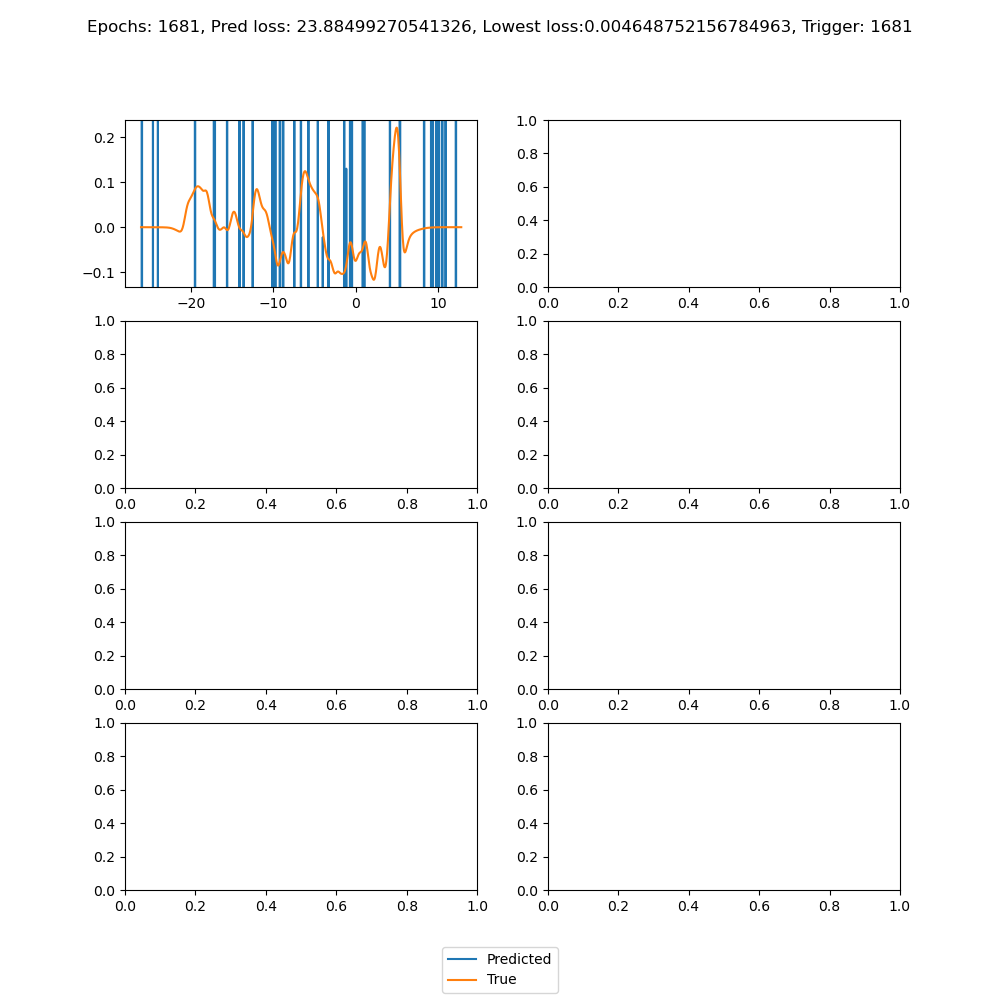

/tmp/ipykernel_574043/927488179.py:87: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([line,z], labels = ["Predicted", "True"], loc = "lower center")
Epoch: 2:   0%|                                                                                                             | 2/20000 [01:51<332:45:00, 59.90s/it, lowest_loss=0.00465, pred_loss=0.259, trigger=2]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 4:   0%|                                                                                                              | 4/20000 [04:10<345:40:36, 62.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=4]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 6:   0%|                                                                                                              | 6/20000 [05:54<303:08:03, 54.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=6]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 8:   0%|                                                                                                              | 8/20000 [07:38<283:18:20, 51.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=8]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 10:   0%|                                                                                                           | 10/20000 [09:18<268:25:17, 48.34s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=10]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 12:   0%|                                                                                                           | 12/20000 [11:09<279:12:02, 50.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=12]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 14:   0%|                                                                                                           | 14/20000 [12:55<277:44:31, 50.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=14]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 16:   0%|                                                                                                           | 16/20000 [14:37<271:19:20, 48.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=16]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 18:   0%|                                                                                                           | 18/20000 [16:27<277:53:30, 50.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=18]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 20:   0%|                                                                                                           | 20/20000 [18:15<279:39:56, 50.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=20]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 22:   0%|                                                                                                           | 22/20000 [19:44<255:15:40, 46.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=22]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 24:   0%|▏                                                                                                          | 24/20000 [21:29<264:44:24, 47.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=24]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 26:   0%|▏                                                                                                          | 26/20000 [22:55<242:32:11, 43.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=26]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 28:   0%|▏                                                                                                          | 28/20000 [24:25<237:16:39, 42.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=28]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 30:   0%|▏                                                                                                          | 30/20000 [26:02<245:03:37, 44.18s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=30]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 32:   0%|▏                                                                                                          | 32/20000 [27:37<246:25:16, 44.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=32]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 34:   0%|▏                                                                                                          | 34/20000 [29:12<246:43:31, 44.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=34]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 36:   0%|▏                                                                                                          | 36/20000 [30:44<242:07:04, 43.66s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=36]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 38:   0%|▏                                                                                                          | 38/20000 [32:14<239:09:05, 43.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=38]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 40:   0%|▏                                                                                                          | 40/20000 [33:54<249:35:58, 45.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=40]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 42:   0%|▏                                                                                                          | 42/20000 [35:22<237:36:53, 42.86s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=42]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 44:   0%|▏                                                                                                          | 44/20000 [36:58<242:18:20, 43.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=44]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 46:   0%|▏                                                                                                          | 46/20000 [38:29<238:48:57, 43.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=46]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 48:   0%|▎                                                                                                          | 48/20000 [39:59<235:54:51, 42.57s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=48]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 50:   0%|▎                                                                                                          | 50/20000 [41:36<240:44:00, 43.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=50]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 52:   0%|▎                                                                                                          | 52/20000 [43:17<250:28:12, 45.20s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=52]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 54:   0%|▎                                                                                                          | 54/20000 [44:47<240:51:21, 43.47s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=54]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 56:   0%|▎                                                                                                          | 56/20000 [46:18<237:17:06, 42.83s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=56]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 58:   0%|▎                                                                                                          | 58/20000 [47:50<238:07:42, 42.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=58]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 60:   0%|▎                                                                                                          | 60/20000 [49:20<235:00:55, 42.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=60]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 62:   0%|▎                                                                                                          | 62/20000 [50:56<241:17:49, 43.57s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=62]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 64:   0%|▎                                                                                                          | 64/20000 [52:24<234:26:31, 42.34s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=64]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 66:   0%|▎                                                                                                          | 66/20000 [53:57<238:09:09, 43.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=66]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 68:   0%|▎                                                                                                          | 68/20000 [55:32<241:21:47, 43.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=68]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 70:   0%|▎                                                                                                          | 70/20000 [57:05<243:56:27, 44.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=70]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 72:   0%|▍                                                                                                          | 72/20000 [58:27<225:38:34, 40.76s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=72]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 74:   0%|▍                                                                                                          | 74/20000 [59:48<219:13:50, 39.61s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=74]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 76:   0%|▍                                                                                                        | 76/20000 [1:01:17<225:22:38, 40.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=76]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 78:   0%|▍                                                                                                        | 78/20000 [1:02:49<230:29:52, 41.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=78]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 80:   0%|▍                                                                                                        | 80/20000 [1:04:27<240:48:43, 43.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=80]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 82:   0%|▍                                                                                                        | 82/20000 [1:06:00<240:51:07, 43.53s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=82]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 84:   0%|▍                                                                                                        | 84/20000 [1:07:26<234:08:24, 42.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=84]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 86:   0%|▍                                                                                                        | 86/20000 [1:08:53<228:54:58, 41.38s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=86]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 88:   0%|▍                                                                                                        | 88/20000 [1:10:28<236:16:23, 42.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=88]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 90:   0%|▍                                                                                                        | 90/20000 [1:12:09<250:31:03, 45.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=90]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 92:   0%|▍                                                                                                        | 92/20000 [1:13:41<243:47:36, 44.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=92]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 94:   0%|▍                                                                                                        | 94/20000 [1:15:12<241:14:36, 43.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=94]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 96:   0%|▌                                                                                                        | 96/20000 [1:16:48<243:13:41, 43.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=96]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 98:   0%|▌                                                                                                        | 98/20000 [1:18:18<237:47:05, 43.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=98]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 100:   0%|▌                                                                                                     | 100/20000 [1:19:47<235:11:59, 42.55s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=100]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 102:   1%|▌                                                                                                     | 102/20000 [1:21:21<238:49:42, 43.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=102]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 104:   1%|▌                                                                                                     | 104/20000 [1:22:54<238:39:18, 43.18s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=104]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 106:   1%|▌                                                                                                     | 106/20000 [1:24:31<244:38:52, 44.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=106]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 108:   1%|▌                                                                                                     | 108/20000 [1:26:03<240:19:26, 43.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=108]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 110:   1%|▌                                                                                                     | 110/20000 [1:27:30<233:33:49, 42.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=110]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 112:   1%|▌                                                                                                     | 112/20000 [1:28:57<230:43:34, 41.76s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=112]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 114:   1%|▌                                                                                                     | 114/20000 [1:30:32<237:59:38, 43.08s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=114]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 116:   1%|▌                                                                                                     | 116/20000 [1:31:57<228:03:32, 41.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=116]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 118:   1%|▌                                                                                                     | 118/20000 [1:33:24<227:12:06, 41.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=118]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 120:   1%|▌                                                                                                     | 120/20000 [1:34:53<226:55:33, 41.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=120]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 122:   1%|▌                                                                                                     | 122/20000 [1:36:18<223:57:06, 40.56s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=122]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 124:   1%|▋                                                                                                     | 124/20000 [1:37:50<231:56:02, 42.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=124]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 126:   1%|▋                                                                                                     | 126/20000 [1:39:15<226:39:57, 41.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=126]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 128:   1%|▋                                                                                                     | 128/20000 [1:40:41<222:28:08, 40.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=128]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 130:   1%|▋                                                                                                     | 130/20000 [1:42:10<225:52:43, 40.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=130]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 132:   1%|▋                                                                                                     | 132/20000 [1:43:38<227:46:52, 41.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=132]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 134:   1%|▋                                                                                                     | 134/20000 [1:45:10<232:19:08, 42.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=134]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 136:   1%|▋                                                                                                     | 136/20000 [1:46:50<243:04:40, 44.05s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=136]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 138:   1%|▋                                                                                                     | 138/20000 [1:48:21<239:34:42, 43.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=138]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 140:   1%|▋                                                                                                     | 140/20000 [1:49:40<223:01:13, 40.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=140]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 142:   1%|▋                                                                                                     | 142/20000 [1:51:11<228:11:20, 41.37s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=142]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 144:   1%|▋                                                                                                     | 144/20000 [1:52:40<229:49:18, 41.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=144]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 146:   1%|▋                                                                                                     | 146/20000 [1:54:03<220:07:03, 39.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=146]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 148:   1%|▊                                                                                                     | 148/20000 [1:55:27<218:00:45, 39.53s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=148]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 150:   1%|▊                                                                                                     | 150/20000 [1:56:50<214:19:13, 38.87s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=150]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 152:   1%|▊                                                                                                     | 152/20000 [1:58:18<221:11:41, 40.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=152]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 154:   1%|▊                                                                                                     | 154/20000 [1:59:50<228:42:45, 41.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=154]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 156:   1%|▊                                                                                                     | 156/20000 [2:01:26<236:03:51, 42.83s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=156]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 158:   1%|▊                                                                                                     | 158/20000 [2:02:56<236:29:12, 42.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=158]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 160:   1%|▊                                                                                                     | 160/20000 [2:04:29<236:48:49, 42.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=160]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 162:   1%|▊                                                                                                     | 162/20000 [2:06:05<242:10:54, 43.95s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=162]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 164:   1%|▊                                                                                                     | 164/20000 [2:07:32<231:14:28, 41.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=164]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 166:   1%|▊                                                                                                     | 166/20000 [2:08:58<228:10:18, 41.41s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=166]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 168:   1%|▊                                                                                                     | 168/20000 [2:10:35<239:25:26, 43.46s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=168]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 170:   1%|▊                                                                                                     | 170/20000 [2:12:00<228:15:58, 41.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=170]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 172:   1%|▉                                                                                                     | 172/20000 [2:13:36<237:24:43, 43.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=172]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 174:   1%|▉                                                                                                     | 174/20000 [2:15:05<235:21:21, 42.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=174]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 176:   1%|▉                                                                                                     | 176/20000 [2:16:34<233:55:23, 42.48s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=176]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 178:   1%|▉                                                                                                     | 178/20000 [2:18:14<246:33:56, 44.78s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=178]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 180:   1%|▉                                                                                                     | 180/20000 [2:19:38<231:10:38, 41.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=180]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 182:   1%|▉                                                                                                     | 182/20000 [2:21:05<225:43:02, 41.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=182]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 184:   1%|▉                                                                                                     | 184/20000 [2:22:32<225:44:16, 41.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=184]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 186:   1%|▉                                                                                                     | 186/20000 [2:24:03<229:05:38, 41.62s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=186]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 188:   1%|▉                                                                                                     | 188/20000 [2:25:31<226:02:07, 41.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=188]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 190:   1%|▉                                                                                                     | 190/20000 [2:27:04<233:17:19, 42.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=190]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 192:   1%|▉                                                                                                     | 192/20000 [2:28:34<232:22:42, 42.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=192]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 194:   1%|▉                                                                                                     | 194/20000 [2:30:07<235:19:48, 42.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=194]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 196:   1%|▉                                                                                                     | 196/20000 [2:31:35<233:07:06, 42.38s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=196]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 198:   1%|█                                                                                                     | 198/20000 [2:32:56<220:48:44, 40.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=198]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 200:   1%|█                                                                                                     | 200/20000 [2:34:31<232:41:54, 42.31s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=200]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 202:   1%|█                                                                                                     | 202/20000 [2:35:50<219:31:18, 39.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=202]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 204:   1%|█                                                                                                     | 204/20000 [2:37:29<238:31:51, 43.38s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=204]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 206:   1%|█                                                                                                     | 206/20000 [2:38:59<234:57:11, 42.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=206]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 208:   1%|█                                                                                                     | 208/20000 [2:40:35<240:26:35, 43.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=208]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 210:   1%|█                                                                                                     | 210/20000 [2:42:07<237:00:49, 43.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=210]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 212:   1%|█                                                                                                     | 212/20000 [2:43:37<235:54:26, 42.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=212]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 214:   1%|█                                                                                                     | 214/20000 [2:45:08<233:02:17, 42.40s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=214]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 216:   1%|█                                                                                                     | 216/20000 [2:46:51<248:22:53, 45.20s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=216]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 218:   1%|█                                                                                                     | 218/20000 [2:48:22<240:53:49, 43.84s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=218]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 220:   1%|█                                                                                                     | 220/20000 [2:49:55<239:53:01, 43.66s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=220]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 222:   1%|█▏                                                                                                    | 222/20000 [2:51:30<242:00:19, 44.05s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=222]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 224:   1%|█▏                                                                                                    | 224/20000 [2:53:02<240:16:03, 43.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=224]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 226:   1%|█▏                                                                                                    | 226/20000 [2:54:37<241:29:02, 43.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=226]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 228:   1%|█▏                                                                                                    | 228/20000 [2:56:06<234:38:30, 42.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=228]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 230:   1%|█▏                                                                                                    | 230/20000 [2:57:40<236:25:47, 43.05s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=230]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 232:   1%|█▏                                                                                                    | 232/20000 [2:59:17<241:42:28, 44.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=232]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 234:   1%|█▏                                                                                                    | 234/20000 [3:00:43<231:13:40, 42.11s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=234]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 236:   1%|█▏                                                                                                    | 236/20000 [3:02:13<232:17:22, 42.31s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=236]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 238:   1%|█▏                                                                                                    | 238/20000 [3:03:37<223:38:05, 40.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=238]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 240:   1%|█▏                                                                                                    | 240/20000 [3:05:03<220:40:51, 40.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=240]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 242:   1%|█▏                                                                                                    | 242/20000 [3:06:34<227:59:03, 41.54s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=242]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 244:   1%|█▏                                                                                                    | 244/20000 [3:08:03<227:40:58, 41.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=244]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 246:   1%|█▎                                                                                                    | 246/20000 [3:09:34<232:47:35, 42.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=246]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 248:   1%|█▎                                                                                                    | 248/20000 [3:11:10<239:15:22, 43.61s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=248]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 250:   1%|█▎                                                                                                    | 250/20000 [3:12:35<229:31:00, 41.84s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=250]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 252:   1%|█▎                                                                                                    | 252/20000 [3:14:16<244:18:13, 44.54s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=252]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 254:   1%|█▎                                                                                                    | 254/20000 [3:15:50<239:05:00, 43.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=254]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 256:   1%|█▎                                                                                                    | 256/20000 [3:17:22<239:08:51, 43.60s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=256]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 258:   1%|█▎                                                                                                    | 258/20000 [3:18:58<242:40:01, 44.25s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=258]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 260:   1%|█▎                                                                                                    | 260/20000 [3:20:28<234:19:26, 42.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=260]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 262:   1%|█▎                                                                                                    | 262/20000 [3:22:07<243:41:29, 44.45s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=262]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 264:   1%|█▎                                                                                                    | 264/20000 [3:23:39<239:59:14, 43.78s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=264]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 266:   1%|█▎                                                                                                    | 266/20000 [3:25:04<227:46:29, 41.55s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=266]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 268:   1%|█▎                                                                                                    | 268/20000 [3:26:35<228:49:36, 41.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=268]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 270:   1%|█▍                                                                                                    | 270/20000 [3:28:04<228:35:09, 41.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=270]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 272:   1%|█▍                                                                                                    | 272/20000 [3:29:21<211:41:44, 38.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=272]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 274:   1%|█▍                                                                                                    | 274/20000 [3:30:40<207:44:35, 37.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=274]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 276:   1%|█▍                                                                                                    | 276/20000 [3:32:05<214:38:15, 39.18s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=276]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 278:   1%|█▍                                                                                                    | 278/20000 [3:33:32<218:32:41, 39.89s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=278]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 280:   1%|█▍                                                                                                    | 280/20000 [3:34:55<216:24:54, 39.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=280]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 282:   1%|█▍                                                                                                    | 282/20000 [3:36:25<222:16:31, 40.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=282]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 284:   1%|█▍                                                                                                    | 284/20000 [3:37:54<225:19:05, 41.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=284]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 286:   1%|█▍                                                                                                    | 286/20000 [3:39:20<222:12:41, 40.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=286]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 288:   1%|█▍                                                                                                    | 288/20000 [3:40:48<225:20:01, 41.15s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=288]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 290:   1%|█▍                                                                                                    | 290/20000 [3:42:20<230:19:30, 42.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=290]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 292:   1%|█▍                                                                                                    | 292/20000 [3:43:43<220:33:37, 40.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=292]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 294:   1%|█▍                                                                                                    | 294/20000 [3:45:17<229:57:11, 42.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=294]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 296:   1%|█▌                                                                                                    | 296/20000 [3:46:49<234:29:34, 42.84s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=296]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 298:   1%|█▌                                                                                                    | 298/20000 [3:48:21<235:09:45, 42.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=298]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 300:   2%|█▌                                                                                                    | 300/20000 [3:49:57<239:39:35, 43.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=300]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 302:   2%|█▌                                                                                                    | 302/20000 [3:51:27<232:53:20, 42.56s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=302]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 304:   2%|█▌                                                                                                    | 304/20000 [3:52:58<232:09:54, 42.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=304]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 306:   2%|█▌                                                                                                    | 306/20000 [3:54:30<235:15:19, 43.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=306]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 308:   2%|█▌                                                                                                    | 308/20000 [3:55:57<230:50:29, 42.20s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=308]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 310:   2%|█▌                                                                                                    | 310/20000 [3:57:31<236:02:13, 43.16s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=310]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 312:   2%|█▌                                                                                                    | 312/20000 [3:59:11<244:09:14, 44.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=312]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 314:   2%|█▌                                                                                                    | 314/20000 [4:00:48<246:43:35, 45.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=314]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 316:   2%|█▌                                                                                                    | 316/20000 [4:02:23<244:48:49, 44.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=316]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 318:   2%|█▌                                                                                                    | 318/20000 [4:04:00<244:16:19, 44.68s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=318]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 320:   2%|█▋                                                                                                    | 320/20000 [4:05:32<241:05:14, 44.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=320]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 322:   2%|█▋                                                                                                    | 322/20000 [4:06:50<221:28:44, 40.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=322]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 324:   2%|█▋                                                                                                    | 324/20000 [4:08:25<233:03:00, 42.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=324]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 326:   2%|█▋                                                                                                    | 326/20000 [4:09:52<227:33:17, 41.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=326]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 328:   2%|█▋                                                                                                    | 328/20000 [4:11:23<230:19:58, 42.15s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=328]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 330:   2%|█▋                                                                                                    | 330/20000 [4:12:55<234:22:35, 42.90s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=330]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 332:   2%|█▋                                                                                                    | 332/20000 [4:14:26<232:05:12, 42.48s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=332]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 334:   2%|█▋                                                                                                    | 334/20000 [4:15:58<233:25:47, 42.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=334]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 336:   2%|█▋                                                                                                    | 336/20000 [4:17:18<219:48:04, 40.24s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=336]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 338:   2%|█▋                                                                                                    | 338/20000 [4:18:49<224:18:17, 41.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=338]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 340:   2%|█▋                                                                                                    | 340/20000 [4:20:17<224:02:40, 41.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=340]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 342:   2%|█▋                                                                                                    | 342/20000 [4:21:40<216:50:36, 39.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=342]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 344:   2%|█▊                                                                                                    | 344/20000 [4:23:22<238:43:12, 43.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=344]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 346:   2%|█▊                                                                                                    | 346/20000 [4:24:55<238:17:09, 43.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=346]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 348:   2%|█▊                                                                                                    | 348/20000 [4:26:22<229:06:39, 41.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=348]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 350:   2%|█▊                                                                                                    | 350/20000 [4:27:50<226:35:18, 41.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=350]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 352:   2%|█▊                                                                                                    | 352/20000 [4:29:21<230:57:09, 42.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=352]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 354:   2%|█▊                                                                                                    | 354/20000 [4:31:04<245:33:27, 45.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=354]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 356:   2%|█▊                                                                                                    | 356/20000 [4:32:39<242:52:07, 44.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=356]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 358:   2%|█▊                                                                                                    | 358/20000 [4:34:07<233:32:05, 42.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=358]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 360:   2%|█▊                                                                                                    | 360/20000 [4:35:32<226:22:12, 41.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=360]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 362:   2%|█▊                                                                                                    | 362/20000 [4:37:05<232:05:00, 42.55s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=362]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 364:   2%|█▊                                                                                                    | 364/20000 [4:38:34<228:03:24, 41.81s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=364]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 366:   2%|█▊                                                                                                    | 366/20000 [4:40:05<230:19:55, 42.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=366]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 368:   2%|█▉                                                                                                    | 368/20000 [4:41:32<224:22:19, 41.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=368]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 370:   2%|█▉                                                                                                    | 370/20000 [4:42:58<222:53:47, 40.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=370]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 372:   2%|█▉                                                                                                    | 372/20000 [4:44:31<230:39:20, 42.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=372]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 374:   2%|█▉                                                                                                    | 374/20000 [4:45:58<227:00:51, 41.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=374]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 376:   2%|█▉                                                                                                    | 376/20000 [4:47:34<236:38:27, 43.41s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=376]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 378:   2%|█▉                                                                                                    | 378/20000 [4:49:02<232:01:46, 42.57s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=378]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 380:   2%|█▉                                                                                                    | 380/20000 [4:50:38<237:22:15, 43.55s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=380]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 382:   2%|█▉                                                                                                    | 382/20000 [4:52:01<223:07:01, 40.94s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=382]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 384:   2%|█▉                                                                                                    | 384/20000 [4:53:36<232:37:06, 42.69s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=384]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 386:   2%|█▉                                                                                                    | 386/20000 [4:55:07<232:07:19, 42.60s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=386]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 388:   2%|█▉                                                                                                    | 388/20000 [4:56:36<228:51:48, 42.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=388]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 390:   2%|█▉                                                                                                    | 390/20000 [4:58:02<222:57:24, 40.93s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=390]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 392:   2%|█▉                                                                                                    | 392/20000 [4:59:35<228:52:23, 42.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=392]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 394:   2%|██                                                                                                    | 394/20000 [5:01:09<233:12:59, 42.82s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=394]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 396:   2%|██                                                                                                    | 396/20000 [5:02:39<230:48:54, 42.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=396]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 398:   2%|██                                                                                                    | 398/20000 [5:04:08<226:06:36, 41.53s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=398]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 400:   2%|██                                                                                                    | 400/20000 [5:05:31<217:17:48, 39.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=400]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 402:   2%|██                                                                                                    | 402/20000 [5:06:46<204:41:09, 37.60s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=402]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 404:   2%|██                                                                                                    | 404/20000 [5:07:59<195:08:35, 35.85s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=404]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 406:   2%|██                                                                                                    | 406/20000 [5:09:04<180:49:40, 33.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=406]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 408:   2%|██                                                                                                    | 408/20000 [5:10:12<175:58:38, 32.34s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=408]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 410:   2%|██                                                                                                    | 410/20000 [5:11:25<181:01:17, 33.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=410]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 412:   2%|██                                                                                                    | 412/20000 [5:12:42<189:16:53, 34.79s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=412]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 414:   2%|██                                                                                                    | 414/20000 [5:14:03<197:25:53, 36.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=414]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 416:   2%|██                                                                                                    | 416/20000 [5:15:14<189:11:55, 34.78s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=416]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 418:   2%|██▏                                                                                                   | 418/20000 [5:16:29<189:17:57, 34.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=418]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 420:   2%|██▏                                                                                                   | 420/20000 [5:17:46<191:18:19, 35.17s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=420]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 422:   2%|██▏                                                                                                   | 422/20000 [5:18:57<184:45:36, 33.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=422]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 424:   2%|██▏                                                                                                   | 424/20000 [5:20:09<183:54:57, 33.82s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=424]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 426:   2%|██▏                                                                                                   | 426/20000 [5:21:29<193:41:47, 35.62s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=426]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 428:   2%|██▏                                                                                                   | 428/20000 [5:22:40<185:26:35, 34.11s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=428]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 430:   2%|██▏                                                                                                   | 430/20000 [5:23:58<190:26:25, 35.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=430]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 432:   2%|██▏                                                                                                   | 432/20000 [5:25:17<195:39:19, 36.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=432]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 434:   2%|██▏                                                                                                   | 434/20000 [5:26:34<195:49:37, 36.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=434]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 436:   2%|██▏                                                                                                   | 436/20000 [5:27:48<191:51:55, 35.31s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=436]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 438:   2%|██▏                                                                                                   | 438/20000 [5:29:01<187:52:46, 34.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=438]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 440:   2%|██▏                                                                                                   | 440/20000 [5:30:08<181:06:05, 33.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=440]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 442:   2%|██▎                                                                                                   | 442/20000 [5:31:25<188:20:39, 34.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=442]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 444:   2%|██▎                                                                                                   | 444/20000 [5:32:42<191:51:18, 35.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=444]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 446:   2%|██▎                                                                                                   | 446/20000 [5:33:52<183:46:47, 33.83s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=446]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 448:   2%|██▎                                                                                                   | 448/20000 [5:35:09<190:00:52, 34.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=448]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 450:   2%|██▎                                                                                                   | 450/20000 [5:36:14<177:24:55, 32.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=450]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 452:   2%|██▎                                                                                                   | 452/20000 [5:37:29<185:08:09, 34.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=452]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 454:   2%|██▎                                                                                                   | 454/20000 [5:38:53<198:21:55, 36.54s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=454]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 456:   2%|██▎                                                                                                   | 456/20000 [5:40:05<191:58:29, 35.36s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=456]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 458:   2%|██▎                                                                                                   | 458/20000 [5:41:19<192:14:00, 35.41s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=458]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 460:   2%|██▎                                                                                                   | 460/20000 [5:42:34<191:37:24, 35.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=460]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 462:   2%|██▎                                                                                                   | 462/20000 [5:43:53<194:30:05, 35.84s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=462]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 464:   2%|██▎                                                                                                   | 464/20000 [5:45:08<192:25:49, 35.46s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=464]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 466:   2%|██▍                                                                                                   | 466/20000 [5:46:26<195:29:20, 36.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=466]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 468:   2%|██▍                                                                                                   | 468/20000 [5:47:43<195:31:46, 36.04s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=468]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 470:   2%|██▍                                                                                                   | 470/20000 [5:48:53<188:11:03, 34.69s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=470]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 472:   2%|██▍                                                                                                   | 472/20000 [5:50:01<179:08:19, 33.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=472]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 474:   2%|██▍                                                                                                   | 474/20000 [5:51:10<177:44:22, 32.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=474]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 476:   2%|██▍                                                                                                   | 476/20000 [5:52:28<188:44:32, 34.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=476]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 478:   2%|██▍                                                                                                   | 478/20000 [5:53:44<189:32:15, 34.95s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=478]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 480:   2%|██▍                                                                                                   | 480/20000 [5:55:02<192:54:36, 35.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=480]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 482:   2%|██▍                                                                                                   | 482/20000 [5:56:17<192:30:08, 35.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=482]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 484:   2%|██▍                                                                                                   | 484/20000 [5:57:33<194:23:24, 35.86s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=484]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 486:   2%|██▍                                                                                                   | 486/20000 [5:58:53<196:59:57, 36.34s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=486]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 488:   2%|██▍                                                                                                   | 488/20000 [6:00:12<197:21:09, 36.41s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=488]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 490:   2%|██▍                                                                                                   | 490/20000 [6:01:30<198:39:51, 36.66s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=490]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 492:   2%|██▌                                                                                                   | 492/20000 [6:02:44<190:20:13, 35.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=492]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 494:   2%|██▌                                                                                                   | 494/20000 [6:04:05<199:14:55, 36.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=494]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 496:   2%|██▌                                                                                                   | 496/20000 [6:05:22<196:06:47, 36.20s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=496]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 498:   2%|██▌                                                                                                   | 498/20000 [6:06:31<183:47:45, 33.93s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=498]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 500:   2%|██▌                                                                                                   | 500/20000 [6:07:44<181:51:21, 33.57s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=500]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 502:   3%|██▌                                                                                                   | 502/20000 [6:08:57<183:00:08, 33.79s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=502]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 504:   3%|██▌                                                                                                   | 504/20000 [6:10:14<188:09:20, 34.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=504]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 506:   3%|██▌                                                                                                   | 506/20000 [6:11:23<179:54:11, 33.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=506]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 508:   3%|██▌                                                                                                   | 508/20000 [6:12:28<171:58:05, 31.76s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=508]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 510:   3%|██▌                                                                                                   | 510/20000 [6:13:42<179:16:48, 33.11s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=510]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 512:   3%|██▌                                                                                                   | 512/20000 [6:14:55<180:13:20, 33.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=512]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 514:   3%|██▌                                                                                                   | 514/20000 [6:16:02<174:22:06, 32.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=514]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 516:   3%|██▋                                                                                                   | 516/20000 [6:17:15<180:03:23, 33.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=516]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 518:   3%|██▋                                                                                                   | 518/20000 [6:18:24<178:32:55, 32.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=518]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 520:   3%|██▋                                                                                                   | 520/20000 [6:19:38<182:52:50, 33.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=520]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 522:   3%|██▋                                                                                                   | 522/20000 [6:20:54<190:36:01, 35.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=522]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 524:   3%|██▋                                                                                                   | 524/20000 [6:22:06<186:15:47, 34.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=524]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 526:   3%|██▋                                                                                                   | 526/20000 [6:23:19<186:11:24, 34.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=526]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 528:   3%|██▋                                                                                                   | 528/20000 [6:24:25<175:43:40, 32.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=528]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 530:   3%|██▋                                                                                                   | 530/20000 [6:25:43<187:00:57, 34.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=530]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 532:   3%|██▋                                                                                                   | 532/20000 [6:27:00<193:00:07, 35.69s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=532]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 534:   3%|██▋                                                                                                   | 534/20000 [6:28:13<189:17:55, 35.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=534]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 536:   3%|██▋                                                                                                   | 536/20000 [6:29:26<186:28:24, 34.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=536]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 538:   3%|██▋                                                                                                   | 538/20000 [6:30:37<183:18:31, 33.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=538]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 540:   3%|██▊                                                                                                   | 540/20000 [6:31:56<190:57:17, 35.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=540]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 542:   3%|██▊                                                                                                   | 542/20000 [6:33:12<192:20:08, 35.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=542]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 544:   3%|██▊                                                                                                   | 544/20000 [6:34:28<191:19:43, 35.40s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=544]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 546:   3%|██▊                                                                                                   | 546/20000 [6:35:42<189:06:09, 34.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=546]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 548:   3%|██▊                                                                                                   | 548/20000 [6:37:06<200:49:29, 37.17s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=548]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 550:   3%|██▊                                                                                                   | 550/20000 [6:38:27<202:36:50, 37.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=550]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 552:   3%|██▊                                                                                                   | 552/20000 [6:39:49<205:32:03, 38.05s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=552]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 554:   3%|██▊                                                                                                   | 554/20000 [6:41:02<196:13:59, 36.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=554]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 556:   3%|██▊                                                                                                   | 556/20000 [6:42:23<200:09:55, 37.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=556]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 558:   3%|██▊                                                                                                   | 558/20000 [6:43:49<207:17:10, 38.38s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=558]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 560:   3%|██▊                                                                                                   | 560/20000 [6:45:00<193:45:16, 35.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=560]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 562:   3%|██▊                                                                                                   | 562/20000 [6:46:25<205:23:50, 38.04s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=562]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 564:   3%|██▉                                                                                                   | 564/20000 [6:47:35<190:26:06, 35.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=564]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 566:   3%|██▉                                                                                                   | 566/20000 [6:48:51<191:56:32, 35.56s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=566]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 568:   3%|██▉                                                                                                   | 568/20000 [6:50:04<185:42:41, 34.41s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=568]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 570:   3%|██▉                                                                                                   | 570/20000 [6:51:19<186:43:46, 34.60s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=570]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 572:   3%|██▉                                                                                                   | 572/20000 [6:52:36<191:07:58, 35.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=572]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 574:   3%|██▉                                                                                                   | 574/20000 [6:53:50<190:55:13, 35.38s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=574]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 576:   3%|██▉                                                                                                   | 576/20000 [6:55:07<193:28:29, 35.86s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=576]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 578:   3%|██▉                                                                                                   | 578/20000 [6:56:22<193:21:06, 35.84s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=578]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 580:   3%|██▉                                                                                                   | 580/20000 [6:57:33<184:36:48, 34.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=580]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 582:   3%|██▉                                                                                                   | 582/20000 [6:58:43<180:07:28, 33.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=582]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 584:   3%|██▉                                                                                                   | 584/20000 [6:59:44<169:16:27, 31.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=584]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 586:   3%|██▉                                                                                                   | 586/20000 [7:00:58<177:45:09, 32.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=586]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 588:   3%|██▉                                                                                                   | 588/20000 [7:02:12<184:03:30, 34.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=588]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 590:   3%|███                                                                                                   | 590/20000 [7:03:27<186:05:12, 34.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=590]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 592:   3%|███                                                                                                   | 592/20000 [7:04:40<186:31:26, 34.60s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=592]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 594:   3%|███                                                                                                   | 594/20000 [7:05:54<186:17:46, 34.56s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=594]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 596:   3%|███                                                                                                   | 596/20000 [7:07:09<188:38:36, 35.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=596]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 598:   3%|███                                                                                                   | 598/20000 [7:08:33<200:46:02, 37.25s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=598]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 600:   3%|███                                                                                                   | 600/20000 [7:09:47<193:28:26, 35.90s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=600]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 602:   3%|███                                                                                                   | 602/20000 [7:10:58<187:45:56, 34.85s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=602]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 604:   3%|███                                                                                                   | 604/20000 [7:12:14<189:13:46, 35.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=604]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 606:   3%|███                                                                                                   | 606/20000 [7:13:27<185:04:23, 34.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=606]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 608:   3%|███                                                                                                   | 608/20000 [7:14:40<185:38:19, 34.46s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=608]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 610:   3%|███                                                                                                   | 610/20000 [7:15:57<189:46:08, 35.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=610]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 612:   3%|███                                                                                                   | 612/20000 [7:17:09<185:44:48, 34.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=612]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 614:   3%|███▏                                                                                                  | 614/20000 [7:18:32<198:43:45, 36.90s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=614]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 616:   3%|███▏                                                                                                  | 616/20000 [7:19:53<200:19:11, 37.20s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=616]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 618:   3%|███▏                                                                                                  | 618/20000 [7:21:09<196:22:28, 36.47s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=618]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 620:   3%|███▏                                                                                                  | 620/20000 [7:22:21<189:04:22, 35.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=620]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 622:   3%|███▏                                                                                                  | 622/20000 [7:23:32<182:27:43, 33.90s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=622]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 624:   3%|███▏                                                                                                  | 624/20000 [7:24:42<181:02:02, 33.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=624]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 626:   3%|███▏                                                                                                  | 626/20000 [7:26:06<197:15:25, 36.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=626]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 628:   3%|███▏                                                                                                  | 628/20000 [7:27:17<186:35:21, 34.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=628]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 630:   3%|███▏                                                                                                  | 630/20000 [7:28:36<193:05:48, 35.89s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=630]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 632:   3%|███▏                                                                                                  | 632/20000 [7:29:50<189:01:03, 35.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=632]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 634:   3%|███▏                                                                                                  | 634/20000 [7:31:10<196:59:56, 36.62s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=634]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 636:   3%|███▏                                                                                                  | 636/20000 [7:32:26<193:43:46, 36.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=636]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 638:   3%|███▎                                                                                                  | 638/20000 [7:33:37<186:36:14, 34.70s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=638]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 640:   3%|███▎                                                                                                  | 640/20000 [7:34:51<185:05:41, 34.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=640]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 642:   3%|███▎                                                                                                  | 642/20000 [7:35:53<172:00:05, 31.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=642]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 644:   3%|███▎                                                                                                  | 644/20000 [7:37:10<182:21:15, 33.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=644]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 646:   3%|███▎                                                                                                  | 646/20000 [7:38:19<177:53:06, 33.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=646]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 648:   3%|███▎                                                                                                  | 648/20000 [7:39:30<177:16:13, 32.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=648]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 650:   3%|███▎                                                                                                  | 650/20000 [7:40:36<171:46:04, 31.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=650]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 652:   3%|███▎                                                                                                  | 652/20000 [7:41:54<184:49:07, 34.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=652]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 654:   3%|███▎                                                                                                  | 654/20000 [7:43:02<177:33:58, 33.04s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=654]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 656:   3%|███▎                                                                                                  | 656/20000 [7:44:20<188:35:26, 35.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=656]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 658:   3%|███▎                                                                                                  | 658/20000 [7:45:44<201:27:32, 37.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=658]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 660:   3%|███▎                                                                                                  | 660/20000 [7:46:56<191:22:30, 35.62s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=660]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 662:   3%|███▍                                                                                                  | 662/20000 [7:48:10<186:24:52, 34.70s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=662]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 664:   3%|███▍                                                                                                  | 664/20000 [7:49:19<178:34:37, 33.25s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=664]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 666:   3%|███▍                                                                                                  | 666/20000 [7:50:28<177:03:34, 32.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=666]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 668:   3%|███▍                                                                                                  | 668/20000 [7:51:39<178:50:42, 33.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=668]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 670:   3%|███▍                                                                                                  | 670/20000 [7:52:52<181:12:56, 33.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=670]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 672:   3%|███▍                                                                                                  | 672/20000 [7:54:05<182:37:11, 34.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=672]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 674:   3%|███▍                                                                                                  | 674/20000 [7:55:27<194:06:46, 36.16s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=674]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 676:   3%|███▍                                                                                                  | 676/20000 [7:56:50<200:39:33, 37.38s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=676]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 678:   3%|███▍                                                                                                  | 678/20000 [7:58:04<192:47:40, 35.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=678]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 680:   3%|███▍                                                                                                  | 680/20000 [7:59:14<183:47:23, 34.25s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=680]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 682:   3%|███▍                                                                                                  | 682/20000 [8:00:32<188:02:05, 35.04s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=682]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 684:   3%|███▍                                                                                                  | 684/20000 [8:01:50<191:37:24, 35.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=684]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 686:   3%|███▍                                                                                                  | 686/20000 [8:03:07<192:52:23, 35.95s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=686]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 688:   3%|███▌                                                                                                  | 688/20000 [8:04:27<198:38:52, 37.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=688]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 690:   3%|███▌                                                                                                  | 690/20000 [8:05:38<185:45:00, 34.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=690]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 692:   3%|███▌                                                                                                  | 692/20000 [8:06:56<190:24:38, 35.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=692]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 694:   3%|███▌                                                                                                  | 694/20000 [8:08:09<187:00:19, 34.87s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=694]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 696:   3%|███▌                                                                                                  | 696/20000 [8:09:26<190:06:26, 35.45s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=696]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 698:   3%|███▌                                                                                                  | 698/20000 [8:10:43<191:51:42, 35.78s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=698]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 700:   4%|███▌                                                                                                  | 700/20000 [8:11:56<188:31:09, 35.16s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=700]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 702:   4%|███▌                                                                                                  | 702/20000 [8:13:08<184:11:33, 34.36s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=702]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 704:   4%|███▌                                                                                                  | 704/20000 [8:14:08<166:57:19, 31.15s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=704]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 706:   4%|███▌                                                                                                  | 706/20000 [8:15:21<174:04:56, 32.48s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=706]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 708:   4%|███▌                                                                                                  | 708/20000 [8:16:31<173:05:54, 32.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=708]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 710:   4%|███▌                                                                                                  | 710/20000 [8:17:49<185:39:27, 34.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=710]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 712:   4%|███▋                                                                                                  | 712/20000 [8:18:57<176:23:13, 32.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=712]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 714:   4%|███▋                                                                                                  | 714/20000 [8:20:12<183:15:02, 34.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=714]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 716:   4%|███▋                                                                                                  | 716/20000 [8:21:24<180:57:24, 33.78s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=716]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 718:   4%|███▋                                                                                                  | 718/20000 [8:22:41<186:38:25, 34.85s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=718]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 720:   4%|███▋                                                                                                  | 720/20000 [8:23:48<178:14:38, 33.28s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=720]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 722:   4%|███▋                                                                                                  | 722/20000 [8:25:06<186:05:01, 34.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=722]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 724:   4%|███▋                                                                                                  | 724/20000 [8:26:17<183:54:33, 34.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=724]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 726:   4%|███▋                                                                                                  | 726/20000 [8:27:37<193:24:41, 36.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=726]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 728:   4%|███▋                                                                                                  | 728/20000 [8:28:49<186:21:12, 34.81s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=728]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 730:   4%|███▋                                                                                                  | 730/20000 [8:30:04<187:20:02, 35.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=730]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 732:   4%|███▋                                                                                                  | 732/20000 [8:31:17<185:10:41, 34.60s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=732]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 734:   4%|███▋                                                                                                  | 734/20000 [8:32:29<181:45:58, 33.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=734]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 736:   4%|███▊                                                                                                  | 736/20000 [8:33:38<178:11:37, 33.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=736]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 738:   4%|███▊                                                                                                  | 738/20000 [8:34:47<175:18:46, 32.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=738]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 740:   4%|███▊                                                                                                  | 740/20000 [8:36:00<178:49:03, 33.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=740]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 742:   4%|███▊                                                                                                  | 742/20000 [8:37:04<169:41:45, 31.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=742]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 744:   4%|███▊                                                                                                  | 744/20000 [8:38:20<180:27:39, 33.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=744]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 746:   4%|███▊                                                                                                  | 746/20000 [8:39:31<180:36:57, 33.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=746]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 748:   4%|███▊                                                                                                  | 748/20000 [8:40:42<177:41:24, 33.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=748]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 750:   4%|███▊                                                                                                  | 750/20000 [8:41:53<178:04:16, 33.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=750]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 752:   4%|███▊                                                                                                  | 752/20000 [8:43:11<185:08:48, 34.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=752]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 754:   4%|███▊                                                                                                  | 754/20000 [8:44:23<181:33:05, 33.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=754]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 756:   4%|███▊                                                                                                  | 756/20000 [8:45:33<176:23:25, 33.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=756]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 758:   4%|███▊                                                                                                  | 758/20000 [8:46:54<191:03:56, 35.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=758]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 760:   4%|███▉                                                                                                  | 760/20000 [8:48:21<203:59:01, 38.17s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=760]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 762:   4%|███▉                                                                                                  | 762/20000 [8:49:42<203:16:36, 38.04s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=762]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 764:   4%|███▉                                                                                                  | 764/20000 [8:50:47<184:20:45, 34.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=764]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 766:   4%|███▉                                                                                                  | 766/20000 [8:52:03<187:44:56, 35.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=766]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 768:   4%|███▉                                                                                                  | 768/20000 [8:53:17<185:08:46, 34.66s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=768]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 770:   4%|███▉                                                                                                  | 770/20000 [8:54:40<196:46:21, 36.84s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=770]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 772:   4%|███▉                                                                                                  | 772/20000 [8:55:45<181:16:23, 33.94s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=772]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 774:   4%|███▉                                                                                                  | 774/20000 [8:56:56<177:56:15, 33.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=774]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 776:   4%|███▉                                                                                                  | 776/20000 [8:58:15<189:33:49, 35.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=776]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 778:   4%|███▉                                                                                                  | 778/20000 [8:59:28<186:04:38, 34.85s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=778]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 780:   4%|███▉                                                                                                  | 780/20000 [9:00:28<166:38:05, 31.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=780]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 782:   4%|███▉                                                                                                  | 782/20000 [9:01:44<179:31:15, 33.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=782]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 784:   4%|███▉                                                                                                  | 784/20000 [9:02:52<173:30:10, 32.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=784]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 786:   4%|████                                                                                                  | 786/20000 [9:04:08<182:22:21, 34.17s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=786]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 788:   4%|████                                                                                                  | 788/20000 [9:05:19<179:16:09, 33.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=788]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 790:   4%|████                                                                                                  | 790/20000 [9:06:38<188:44:04, 35.37s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=790]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 792:   4%|████                                                                                                  | 792/20000 [9:07:56<192:56:57, 36.16s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=792]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 794:   4%|████                                                                                                  | 794/20000 [9:09:09<187:27:03, 35.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=794]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 796:   4%|████                                                                                                  | 796/20000 [9:10:29<193:41:27, 36.31s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=796]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 798:   4%|████                                                                                                  | 798/20000 [9:11:44<191:53:18, 35.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=798]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 800:   4%|████                                                                                                  | 800/20000 [9:13:00<190:01:07, 35.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=800]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 802:   4%|████                                                                                                  | 802/20000 [9:14:10<182:48:18, 34.28s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=802]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 804:   4%|████                                                                                                  | 804/20000 [9:15:35<196:58:12, 36.94s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=804]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 806:   4%|████                                                                                                  | 806/20000 [9:16:40<178:31:25, 33.48s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=806]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 808:   4%|████                                                                                                  | 808/20000 [9:18:00<190:03:06, 35.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=808]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 810:   4%|████▏                                                                                                 | 810/20000 [9:19:20<194:28:43, 36.48s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=810]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 812:   4%|████▏                                                                                                 | 812/20000 [9:20:38<195:58:36, 36.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=812]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 814:   4%|████▏                                                                                                 | 814/20000 [9:21:54<191:09:19, 35.87s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=814]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 816:   4%|████▏                                                                                                 | 816/20000 [9:23:05<184:01:34, 34.53s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=816]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 818:   4%|████▏                                                                                                 | 818/20000 [9:24:24<191:30:23, 35.94s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=818]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 820:   4%|████▏                                                                                                 | 820/20000 [9:25:38<188:27:54, 35.37s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=820]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 822:   4%|████▏                                                                                                 | 822/20000 [9:26:52<186:17:48, 34.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=822]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 824:   4%|████▏                                                                                                 | 824/20000 [9:27:59<176:43:23, 33.18s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=824]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 826:   4%|████▏                                                                                                 | 826/20000 [9:29:15<184:11:35, 34.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=826]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 828:   4%|████▏                                                                                                 | 828/20000 [9:30:34<190:24:23, 35.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=828]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 830:   4%|████▏                                                                                                 | 830/20000 [9:31:47<184:53:47, 34.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=830]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 832:   4%|████▏                                                                                                 | 832/20000 [9:33:05<189:20:39, 35.56s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=832]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 834:   4%|████▎                                                                                                 | 834/20000 [9:34:18<184:32:14, 34.66s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=834]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 836:   4%|████▎                                                                                                 | 836/20000 [9:35:28<180:47:25, 33.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=836]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 838:   4%|████▎                                                                                                 | 838/20000 [9:36:37<178:08:33, 33.47s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=838]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 840:   4%|████▎                                                                                                 | 840/20000 [9:37:48<177:54:28, 33.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=840]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 842:   4%|████▎                                                                                                 | 842/20000 [9:38:57<176:34:27, 33.18s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=842]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 844:   4%|████▎                                                                                                 | 844/20000 [9:40:04<169:21:07, 31.83s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=844]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 846:   4%|████▎                                                                                                 | 846/20000 [9:41:13<168:42:57, 31.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=846]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 848:   4%|████▎                                                                                                 | 848/20000 [9:42:33<182:58:58, 34.40s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=848]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 850:   4%|████▎                                                                                                 | 850/20000 [9:43:45<180:23:39, 33.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=850]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 852:   4%|████▎                                                                                                 | 852/20000 [9:45:04<189:47:43, 35.68s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=852]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 854:   4%|████▎                                                                                                 | 854/20000 [9:46:06<171:11:28, 32.19s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=854]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 856:   4%|████▎                                                                                                 | 856/20000 [9:47:12<168:49:37, 31.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=856]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 858:   4%|████▍                                                                                                 | 858/20000 [9:48:24<172:54:30, 32.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=858]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 860:   4%|████▍                                                                                                 | 860/20000 [9:49:37<178:27:43, 33.57s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=860]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 862:   4%|████▍                                                                                                 | 862/20000 [9:50:52<183:05:09, 34.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=862]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 864:   4%|████▍                                                                                                 | 864/20000 [9:52:03<181:17:33, 34.11s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=864]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 866:   4%|████▍                                                                                                 | 866/20000 [9:53:26<194:05:06, 36.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=866]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 868:   4%|████▍                                                                                                 | 868/20000 [9:54:33<178:54:54, 33.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=868]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 870:   4%|████▍                                                                                                 | 870/20000 [9:55:53<187:49:45, 35.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=870]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 872:   4%|████▍                                                                                                 | 872/20000 [9:57:12<192:48:34, 36.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=872]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 874:   4%|████▍                                                                                                 | 874/20000 [9:58:27<188:38:07, 35.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=874]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 876:   4%|████▍                                                                                                 | 876/20000 [9:59:43<188:55:49, 35.57s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=876]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 878:   4%|████▍                                                                                                | 878/20000 [10:00:59<189:52:58, 35.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=878]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 880:   4%|████▍                                                                                                | 880/20000 [10:02:10<182:52:48, 34.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=880]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 882:   4%|████▍                                                                                                | 882/20000 [10:03:20<177:54:52, 33.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=882]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 884:   4%|████▍                                                                                                | 884/20000 [10:04:35<181:39:56, 34.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=884]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 886:   4%|████▍                                                                                                | 886/20000 [10:05:47<179:24:21, 33.79s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=886]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 888:   4%|████▍                                                                                                | 888/20000 [10:07:02<185:08:25, 34.87s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=888]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 890:   4%|████▍                                                                                                | 890/20000 [10:08:15<182:23:48, 34.36s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=890]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 892:   4%|████▌                                                                                                | 892/20000 [10:09:31<185:47:13, 35.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=892]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 894:   4%|████▌                                                                                                | 894/20000 [10:10:42<179:45:47, 33.87s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=894]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 896:   4%|████▌                                                                                                | 896/20000 [10:11:51<174:13:05, 32.83s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=896]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 898:   4%|████▌                                                                                                | 898/20000 [10:13:12<187:34:02, 35.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=898]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 900:   4%|████▌                                                                                                | 900/20000 [10:14:36<197:28:36, 37.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=900]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 902:   5%|████▌                                                                                                | 902/20000 [10:15:46<185:14:11, 34.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=902]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 904:   5%|████▌                                                                                                | 904/20000 [10:16:56<180:08:24, 33.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=904]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 906:   5%|████▌                                                                                                | 906/20000 [10:18:07<177:32:05, 33.47s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=906]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 908:   5%|████▌                                                                                                | 908/20000 [10:19:13<171:07:16, 32.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=908]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 910:   5%|████▌                                                                                                | 910/20000 [10:20:35<186:25:48, 35.16s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=910]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 912:   5%|████▌                                                                                                | 912/20000 [10:21:50<186:03:13, 35.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=912]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 914:   5%|████▌                                                                                                | 914/20000 [10:23:10<192:06:26, 36.24s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=914]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 916:   5%|████▋                                                                                                | 916/20000 [10:24:13<174:17:17, 32.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=916]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 918:   5%|████▋                                                                                                | 918/20000 [10:25:25<177:11:39, 33.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=918]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 920:   5%|████▋                                                                                                | 920/20000 [10:26:39<179:55:36, 33.95s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=920]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 922:   5%|████▋                                                                                                | 922/20000 [10:27:42<169:51:39, 32.05s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=922]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 924:   5%|████▋                                                                                                | 924/20000 [10:28:46<164:07:25, 30.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=924]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 926:   5%|████▋                                                                                                | 926/20000 [10:29:59<171:43:59, 32.41s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=926]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 928:   5%|████▋                                                                                                | 928/20000 [10:31:19<183:49:45, 34.70s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=928]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 930:   5%|████▋                                                                                                | 930/20000 [10:32:36<186:54:14, 35.28s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=930]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 932:   5%|████▋                                                                                                | 932/20000 [10:33:50<186:55:07, 35.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=932]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 934:   5%|████▋                                                                                                | 934/20000 [10:35:00<180:05:23, 34.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=934]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 936:   5%|████▋                                                                                                | 936/20000 [10:36:13<180:30:12, 34.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=936]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 938:   5%|████▋                                                                                                | 938/20000 [10:37:32<187:44:23, 35.46s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=938]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 940:   5%|████▋                                                                                                | 940/20000 [10:38:42<180:28:33, 34.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=940]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 942:   5%|████▊                                                                                                | 942/20000 [10:40:05<192:55:18, 36.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=942]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 944:   5%|████▊                                                                                                | 944/20000 [10:41:17<185:50:08, 35.11s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=944]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 946:   5%|████▊                                                                                                | 946/20000 [10:42:35<188:20:46, 35.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=946]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 948:   5%|████▊                                                                                                | 948/20000 [10:44:00<198:33:54, 37.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=948]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 950:   5%|████▊                                                                                                | 950/20000 [10:45:19<197:53:12, 37.40s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=950]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 952:   5%|████▊                                                                                                | 952/20000 [10:46:38<197:49:55, 37.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=952]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 954:   5%|████▊                                                                                                | 954/20000 [10:47:53<193:35:06, 36.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=954]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 956:   5%|████▊                                                                                                | 956/20000 [10:49:14<194:16:30, 36.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=956]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 958:   5%|████▊                                                                                                | 958/20000 [10:50:35<197:58:12, 37.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=958]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 960:   5%|████▊                                                                                                | 960/20000 [10:51:49<188:52:56, 35.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=960]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 962:   5%|████▊                                                                                                | 962/20000 [10:53:14<199:10:36, 37.66s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=962]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 964:   5%|████▊                                                                                                | 964/20000 [10:54:40<206:49:28, 39.11s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=964]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 966:   5%|████▉                                                                                                | 966/20000 [10:55:54<196:08:39, 37.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=966]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 968:   5%|████▉                                                                                                | 968/20000 [10:57:22<206:05:14, 38.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=968]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 970:   5%|████▉                                                                                                | 970/20000 [10:58:41<201:34:41, 38.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=970]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 972:   5%|████▉                                                                                                | 972/20000 [11:00:02<199:47:01, 37.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=972]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 974:   5%|████▉                                                                                                | 974/20000 [11:01:18<191:49:14, 36.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=974]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 976:   5%|████▉                                                                                                | 976/20000 [11:02:35<191:32:53, 36.25s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=976]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 978:   5%|████▉                                                                                                | 978/20000 [11:03:46<182:32:10, 34.55s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=978]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 980:   5%|████▉                                                                                                | 980/20000 [11:05:02<186:28:27, 35.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=980]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 982:   5%|████▉                                                                                                | 982/20000 [11:06:20<191:10:30, 36.19s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=982]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 984:   5%|████▉                                                                                                | 984/20000 [11:07:33<187:15:32, 35.45s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=984]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 986:   5%|████▉                                                                                                | 986/20000 [11:08:49<186:03:39, 35.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=986]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 988:   5%|████▉                                                                                                | 988/20000 [11:09:59<180:46:27, 34.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=988]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 990:   5%|████▉                                                                                                | 990/20000 [11:11:08<174:59:05, 33.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=990]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 992:   5%|█████                                                                                                | 992/20000 [11:12:23<179:53:46, 34.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=992]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 994:   5%|█████                                                                                                | 994/20000 [11:13:33<177:03:02, 33.54s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=994]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 996:   5%|█████                                                                                                | 996/20000 [11:14:54<188:29:51, 35.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=996]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 998:   5%|█████                                                                                                | 998/20000 [11:16:05<181:42:18, 34.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=998]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1000:   5%|████▉                                                                                             | 1000/20000 [11:17:28<191:17:54, 36.25s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1000]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1002:   5%|████▉                                                                                             | 1002/20000 [11:18:42<186:57:59, 35.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1002]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1004:   5%|████▉                                                                                             | 1004/20000 [11:19:53<181:45:33, 34.45s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1004]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1006:   5%|████▉                                                                                             | 1006/20000 [11:21:03<175:42:53, 33.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1006]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1008:   5%|████▉                                                                                             | 1008/20000 [11:22:15<177:28:33, 33.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1008]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1010:   5%|████▉                                                                                             | 1010/20000 [11:23:29<179:36:03, 34.05s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1010]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1012:   5%|████▉                                                                                             | 1012/20000 [11:24:49<186:48:58, 35.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1012]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1014:   5%|████▉                                                                                             | 1014/20000 [11:26:03<185:14:31, 35.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1014]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1016:   5%|████▉                                                                                             | 1016/20000 [11:27:25<195:37:19, 37.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1016]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1018:   5%|████▉                                                                                             | 1018/20000 [11:28:35<181:08:32, 34.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1018]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1020:   5%|████▉                                                                                             | 1020/20000 [11:29:45<177:58:30, 33.76s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1020]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1022:   5%|█████                                                                                             | 1022/20000 [11:31:02<182:53:57, 34.69s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1022]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1024:   5%|█████                                                                                             | 1024/20000 [11:32:13<178:54:56, 33.94s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1024]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1026:   5%|█████                                                                                             | 1026/20000 [11:33:27<180:39:29, 34.28s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1026]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1028:   5%|█████                                                                                             | 1028/20000 [11:34:43<184:30:04, 35.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1028]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1030:   5%|█████                                                                                             | 1030/20000 [11:35:53<177:00:12, 33.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1030]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1032:   5%|█████                                                                                             | 1032/20000 [11:37:13<188:56:38, 35.86s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1032]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1034:   5%|█████                                                                                             | 1034/20000 [11:38:31<191:23:41, 36.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1034]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1036:   5%|█████                                                                                             | 1036/20000 [11:39:45<186:09:46, 35.34s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1036]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1038:   5%|█████                                                                                             | 1038/20000 [11:41:00<185:09:25, 35.15s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1038]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1040:   5%|█████                                                                                             | 1040/20000 [11:42:21<191:18:20, 36.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1040]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1042:   5%|█████                                                                                             | 1042/20000 [11:43:40<192:11:44, 36.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1042]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1044:   5%|█████                                                                                             | 1044/20000 [11:44:48<179:22:32, 34.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1044]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1046:   5%|█████▏                                                                                            | 1046/20000 [11:46:04<183:01:30, 34.76s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1046]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1048:   5%|█████▏                                                                                            | 1048/20000 [11:47:24<189:41:09, 36.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1048]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1050:   5%|█████▏                                                                                            | 1050/20000 [11:48:44<193:49:40, 36.82s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1050]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1052:   5%|█████▏                                                                                            | 1052/20000 [11:50:01<190:55:52, 36.28s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1052]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1054:   5%|█████▏                                                                                            | 1054/20000 [11:51:13<184:01:05, 34.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1054]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1056:   5%|█████▏                                                                                            | 1056/20000 [11:52:29<185:19:24, 35.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1056]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1058:   5%|█████▏                                                                                            | 1058/20000 [11:53:50<192:44:15, 36.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1058]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1060:   5%|█████▏                                                                                            | 1060/20000 [11:54:57<176:13:00, 33.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1060]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1062:   5%|█████▏                                                                                            | 1062/20000 [11:56:08<176:20:47, 33.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1062]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1064:   5%|█████▏                                                                                            | 1064/20000 [11:57:16<171:43:28, 32.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1064]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1066:   5%|█████▏                                                                                            | 1066/20000 [11:58:28<174:04:17, 33.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1066]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1068:   5%|█████▏                                                                                            | 1068/20000 [11:59:38<172:34:33, 32.82s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1068]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1070:   5%|█████▏                                                                                            | 1070/20000 [12:00:55<179:09:12, 34.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1070]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1072:   5%|█████▎                                                                                            | 1072/20000 [12:02:06<178:20:16, 33.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1072]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1074:   5%|█████▎                                                                                            | 1074/20000 [12:03:17<177:04:23, 33.68s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1074]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1076:   5%|█████▎                                                                                            | 1076/20000 [12:04:27<173:15:38, 32.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1076]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1078:   5%|█████▎                                                                                            | 1078/20000 [12:05:36<170:25:33, 32.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1078]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1080:   5%|█████▎                                                                                            | 1080/20000 [12:06:49<173:53:30, 33.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1080]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1082:   5%|█████▎                                                                                            | 1082/20000 [12:07:54<166:14:39, 31.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1082]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1084:   5%|█████▎                                                                                            | 1084/20000 [12:09:12<179:19:55, 34.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1084]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1086:   5%|█████▎                                                                                            | 1086/20000 [12:10:29<182:50:43, 34.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1086]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1088:   5%|█████▎                                                                                            | 1088/20000 [12:11:43<182:01:21, 34.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1088]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1090:   5%|█████▎                                                                                            | 1090/20000 [12:12:53<175:16:53, 33.37s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1090]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1092:   5%|█████▎                                                                                            | 1092/20000 [12:13:59<167:42:05, 31.93s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1092]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1094:   5%|█████▎                                                                                            | 1094/20000 [12:15:10<171:26:21, 32.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1094]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1096:   5%|█████▎                                                                                            | 1096/20000 [12:16:25<175:55:04, 33.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1096]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1098:   5%|█████▍                                                                                            | 1098/20000 [12:17:44<186:06:52, 35.45s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1098]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1100:   6%|█████▍                                                                                            | 1100/20000 [12:19:05<192:47:53, 36.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1100]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1102:   6%|█████▍                                                                                            | 1102/20000 [12:20:14<180:17:02, 34.34s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1102]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1104:   6%|█████▍                                                                                            | 1104/20000 [12:21:37<192:49:38, 36.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1104]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1106:   6%|█████▍                                                                                            | 1106/20000 [12:22:56<193:46:21, 36.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1106]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1108:   6%|█████▍                                                                                            | 1108/20000 [12:24:07<184:48:01, 35.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1108]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1110:   6%|█████▍                                                                                            | 1110/20000 [12:25:28<191:50:26, 36.56s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1110]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1112:   6%|█████▍                                                                                            | 1112/20000 [12:26:41<184:14:16, 35.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1112]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1114:   6%|█████▍                                                                                            | 1114/20000 [12:28:02<188:34:01, 35.94s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1114]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1116:   6%|█████▍                                                                                            | 1116/20000 [12:29:24<195:27:48, 37.26s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1116]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1118:   6%|█████▍                                                                                            | 1118/20000 [12:30:39<191:13:59, 36.46s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1118]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1120:   6%|█████▍                                                                                            | 1120/20000 [12:31:55<189:19:29, 36.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1120]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1122:   6%|█████▍                                                                                            | 1122/20000 [12:33:00<175:03:08, 33.38s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1122]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1124:   6%|█████▌                                                                                            | 1124/20000 [12:34:13<176:41:41, 33.70s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1124]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1126:   6%|█████▌                                                                                            | 1126/20000 [12:35:26<178:20:09, 34.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1126]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1128:   6%|█████▌                                                                                            | 1128/20000 [12:36:39<179:34:27, 34.26s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1128]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1130:   6%|█████▌                                                                                            | 1130/20000 [12:37:58<186:49:44, 35.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1130]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1132:   6%|█████▌                                                                                            | 1132/20000 [12:39:04<173:16:08, 33.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1132]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1134:   6%|█████▌                                                                                            | 1134/20000 [12:40:18<176:49:49, 33.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1134]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1136:   6%|█████▌                                                                                            | 1136/20000 [12:41:29<174:31:23, 33.31s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1136]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1138:   6%|█████▌                                                                                            | 1138/20000 [12:42:48<186:23:48, 35.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1138]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1140:   6%|█████▌                                                                                            | 1140/20000 [12:44:02<181:19:41, 34.61s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1140]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1142:   6%|█████▌                                                                                            | 1142/20000 [12:45:16<179:20:28, 34.24s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1142]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1144:   6%|█████▌                                                                                            | 1144/20000 [12:46:23<172:23:09, 32.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1144]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1146:   6%|█████▌                                                                                            | 1146/20000 [12:47:35<174:10:12, 33.26s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1146]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1148:   6%|█████▋                                                                                            | 1148/20000 [12:48:44<172:32:38, 32.95s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1148]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1150:   6%|█████▋                                                                                            | 1150/20000 [12:49:56<175:49:09, 33.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1150]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1152:   6%|█████▋                                                                                            | 1152/20000 [12:51:06<172:23:24, 32.93s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1152]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1154:   6%|█████▋                                                                                            | 1154/20000 [12:52:25<182:59:40, 34.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1154]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1156:   6%|█████▋                                                                                            | 1156/20000 [12:53:38<180:41:15, 34.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1156]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1158:   6%|█████▋                                                                                            | 1158/20000 [12:54:56<186:38:23, 35.66s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1158]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1160:   6%|█████▋                                                                                            | 1160/20000 [12:56:05<176:06:25, 33.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1160]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1162:   6%|█████▋                                                                                            | 1162/20000 [12:57:22<183:38:20, 35.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1162]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1164:   6%|█████▋                                                                                            | 1164/20000 [12:58:42<188:43:43, 36.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1164]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1166:   6%|█████▋                                                                                            | 1166/20000 [13:00:00<190:34:47, 36.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1166]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1168:   6%|█████▋                                                                                            | 1168/20000 [13:01:22<196:14:02, 37.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1168]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1170:   6%|█████▋                                                                                            | 1170/20000 [13:02:39<192:49:35, 36.87s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1170]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1172:   6%|█████▋                                                                                            | 1172/20000 [13:03:56<190:33:57, 36.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1172]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1174:   6%|█████▊                                                                                            | 1174/20000 [13:05:07<182:22:57, 34.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1174]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1176:   6%|█████▊                                                                                            | 1176/20000 [13:06:20<181:19:54, 34.68s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1176]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1178:   6%|█████▊                                                                                            | 1178/20000 [13:07:40<187:50:17, 35.93s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1178]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1180:   6%|█████▊                                                                                            | 1180/20000 [13:08:57<188:34:58, 36.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1180]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1182:   6%|█████▊                                                                                            | 1182/20000 [13:10:10<186:17:10, 35.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1182]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1184:   6%|█████▊                                                                                            | 1184/20000 [13:11:29<188:28:18, 36.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1184]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1186:   6%|█████▊                                                                                            | 1186/20000 [13:12:47<188:47:25, 36.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1186]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1188:   6%|█████▊                                                                                            | 1188/20000 [13:13:54<175:43:17, 33.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1188]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1190:   6%|█████▊                                                                                            | 1190/20000 [13:15:09<179:41:13, 34.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1190]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1192:   6%|█████▊                                                                                            | 1192/20000 [13:16:20<177:34:36, 33.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1192]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1194:   6%|█████▊                                                                                            | 1194/20000 [13:17:33<175:31:40, 33.60s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1194]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1196:   6%|█████▊                                                                                            | 1196/20000 [13:18:44<174:53:06, 33.48s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1196]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1198:   6%|█████▊                                                                                            | 1198/20000 [13:19:58<177:27:11, 33.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1198]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1200:   6%|█████▉                                                                                            | 1200/20000 [13:21:15<183:23:16, 35.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1200]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1202:   6%|█████▉                                                                                            | 1202/20000 [13:22:34<188:12:04, 36.04s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1202]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1204:   6%|█████▉                                                                                            | 1204/20000 [13:23:54<191:42:02, 36.72s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1204]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1206:   6%|█████▉                                                                                            | 1206/20000 [13:25:06<181:49:15, 34.83s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1206]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1208:   6%|█████▉                                                                                            | 1208/20000 [13:26:15<174:29:31, 33.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1208]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1210:   6%|█████▉                                                                                            | 1210/20000 [13:27:30<179:59:48, 34.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1210]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1212:   6%|█████▉                                                                                            | 1212/20000 [13:28:49<185:01:20, 35.45s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1212]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1214:   6%|█████▉                                                                                            | 1214/20000 [13:30:02<181:17:34, 34.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1214]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1216:   6%|█████▉                                                                                            | 1216/20000 [13:31:22<189:17:11, 36.28s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1216]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1218:   6%|█████▉                                                                                            | 1218/20000 [13:32:40<188:37:24, 36.15s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1218]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1220:   6%|█████▉                                                                                            | 1220/20000 [13:33:54<184:01:00, 35.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1220]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1222:   6%|█████▉                                                                                            | 1222/20000 [13:35:08<183:34:42, 35.19s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1222]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1224:   6%|█████▉                                                                                            | 1224/20000 [13:36:25<184:02:14, 35.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1224]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1226:   6%|██████                                                                                            | 1226/20000 [13:37:46<190:26:50, 36.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1226]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1228:   6%|██████                                                                                            | 1228/20000 [13:39:00<185:54:22, 35.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1228]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1230:   6%|██████                                                                                            | 1230/20000 [13:40:20<189:31:39, 36.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1230]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1232:   6%|██████                                                                                            | 1232/20000 [13:41:43<197:09:58, 37.82s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1232]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1234:   6%|██████                                                                                            | 1234/20000 [13:43:09<205:08:00, 39.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1234]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1236:   6%|██████                                                                                            | 1236/20000 [13:44:36<207:50:42, 39.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1236]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1238:   6%|██████                                                                                            | 1238/20000 [13:45:51<193:29:50, 37.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1238]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1240:   6%|██████                                                                                            | 1240/20000 [13:47:01<181:22:14, 34.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1240]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1242:   6%|██████                                                                                            | 1242/20000 [13:48:06<168:29:00, 32.34s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1242]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1244:   6%|██████                                                                                            | 1244/20000 [13:49:25<179:28:45, 34.45s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1244]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1246:   6%|██████                                                                                            | 1246/20000 [13:50:41<180:57:23, 34.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1246]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1248:   6%|██████                                                                                            | 1248/20000 [13:51:50<173:44:10, 33.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1248]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1250:   6%|██████▏                                                                                           | 1250/20000 [13:53:04<177:45:04, 34.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1250]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1252:   6%|██████▏                                                                                           | 1252/20000 [13:54:17<178:47:44, 34.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1252]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1254:   6%|██████▏                                                                                           | 1254/20000 [13:55:32<181:11:06, 34.79s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1254]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1256:   6%|██████▏                                                                                           | 1256/20000 [13:56:48<182:36:12, 35.07s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1256]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1258:   6%|██████▏                                                                                           | 1258/20000 [13:57:50<167:24:34, 32.16s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1258]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1260:   6%|██████▏                                                                                           | 1260/20000 [13:59:02<170:07:03, 32.68s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1260]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1262:   6%|██████▏                                                                                           | 1262/20000 [14:00:13<170:26:55, 32.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1262]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1264:   6%|██████▏                                                                                           | 1264/20000 [14:01:18<164:25:26, 31.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1264]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1266:   6%|██████▏                                                                                           | 1266/20000 [14:02:34<175:06:38, 33.65s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1266]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1268:   6%|██████▏                                                                                           | 1268/20000 [14:03:51<179:46:03, 34.55s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1268]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1270:   6%|██████▏                                                                                           | 1270/20000 [14:05:07<180:51:25, 34.76s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1270]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1272:   6%|██████▏                                                                                           | 1272/20000 [14:06:24<182:13:00, 35.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1272]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1274:   6%|██████▏                                                                                           | 1274/20000 [14:07:36<180:45:52, 34.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1274]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1276:   6%|██████▎                                                                                           | 1276/20000 [14:08:56<187:55:48, 36.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1276]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1278:   6%|██████▎                                                                                           | 1278/20000 [14:10:09<183:32:37, 35.29s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1278]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1280:   6%|██████▎                                                                                           | 1280/20000 [14:11:34<196:02:30, 37.70s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1280]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1282:   6%|██████▎                                                                                           | 1282/20000 [14:12:55<196:54:21, 37.87s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1282]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1284:   6%|██████▎                                                                                           | 1284/20000 [14:14:19<201:13:25, 38.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1284]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1286:   6%|██████▎                                                                                           | 1286/20000 [14:15:35<192:30:18, 37.03s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1286]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1288:   6%|██████▎                                                                                           | 1288/20000 [14:16:54<190:48:35, 36.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1288]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1290:   6%|██████▎                                                                                           | 1290/20000 [14:18:05<180:32:38, 34.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1290]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1292:   6%|██████▎                                                                                           | 1292/20000 [14:19:17<177:08:29, 34.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1292]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1294:   6%|██████▎                                                                                           | 1294/20000 [14:20:37<184:04:42, 35.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1294]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1296:   6%|██████▎                                                                                           | 1296/20000 [14:21:43<172:55:56, 33.28s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1296]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1298:   6%|██████▎                                                                                           | 1298/20000 [14:22:58<175:36:17, 33.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1298]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1300:   6%|██████▎                                                                                           | 1300/20000 [14:24:20<189:22:04, 36.46s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1300]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1302:   7%|██████▍                                                                                           | 1302/20000 [14:25:24<172:04:31, 33.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1302]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1304:   7%|██████▍                                                                                           | 1304/20000 [14:26:37<174:06:38, 33.53s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1304]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1306:   7%|██████▍                                                                                           | 1306/20000 [14:27:47<172:05:28, 33.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1306]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1308:   7%|██████▍                                                                                           | 1308/20000 [14:28:54<167:20:06, 32.23s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1308]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1310:   7%|██████▍                                                                                           | 1310/20000 [14:30:06<169:48:33, 32.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1310]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1312:   7%|██████▍                                                                                           | 1312/20000 [14:31:18<170:57:30, 32.93s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1312]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1314:   7%|██████▍                                                                                           | 1314/20000 [14:32:35<178:44:35, 34.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1314]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1316:   7%|██████▍                                                                                           | 1316/20000 [14:33:50<179:12:39, 34.53s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1316]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1318:   7%|██████▍                                                                                           | 1318/20000 [14:35:05<180:19:48, 34.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1318]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1320:   7%|██████▍                                                                                           | 1320/20000 [14:36:18<180:40:21, 34.82s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1320]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1322:   7%|██████▍                                                                                           | 1322/20000 [14:37:23<169:28:38, 32.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1322]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1324:   7%|██████▍                                                                                           | 1324/20000 [14:38:46<185:35:24, 35.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1324]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1326:   7%|██████▍                                                                                           | 1326/20000 [14:40:07<191:19:09, 36.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1326]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1328:   7%|██████▌                                                                                           | 1328/20000 [14:41:21<184:11:16, 35.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1328]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1330:   7%|██████▌                                                                                           | 1330/20000 [14:42:40<187:35:54, 36.17s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1330]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1332:   7%|██████▌                                                                                           | 1332/20000 [14:43:58<189:07:33, 36.47s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1332]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1334:   7%|██████▌                                                                                           | 1334/20000 [14:45:19<191:45:08, 36.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1334]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1336:   7%|██████▌                                                                                           | 1336/20000 [14:46:30<181:46:42, 35.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1336]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1338:   7%|██████▌                                                                                           | 1338/20000 [14:47:45<179:54:37, 34.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1338]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1340:   7%|██████▌                                                                                           | 1340/20000 [14:48:53<169:40:48, 32.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1340]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1342:   7%|██████▌                                                                                           | 1342/20000 [14:50:12<180:59:03, 34.92s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1342]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1344:   7%|██████▌                                                                                           | 1344/20000 [14:51:26<179:58:10, 34.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1344]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1346:   7%|██████▌                                                                                           | 1346/20000 [14:52:45<183:18:03, 35.37s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1346]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1348:   7%|██████▌                                                                                           | 1348/20000 [14:54:01<185:05:47, 35.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1348]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1350:   7%|██████▌                                                                                           | 1350/20000 [14:55:19<188:04:10, 36.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1350]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1352:   7%|██████▌                                                                                           | 1352/20000 [14:56:35<186:32:47, 36.01s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1352]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1354:   7%|██████▋                                                                                           | 1354/20000 [14:57:59<197:19:17, 38.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1354]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1356:   7%|██████▋                                                                                           | 1356/20000 [14:59:11<186:45:34, 36.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1356]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1358:   7%|██████▋                                                                                           | 1358/20000 [15:00:22<178:36:22, 34.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1358]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1360:   7%|██████▋                                                                                           | 1360/20000 [15:01:36<180:35:18, 34.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1360]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1362:   7%|██████▋                                                                                           | 1362/20000 [15:02:48<175:55:47, 33.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1362]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1364:   7%|██████▋                                                                                           | 1364/20000 [15:04:01<177:08:09, 34.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1364]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1366:   7%|██████▋                                                                                           | 1366/20000 [15:05:15<174:50:39, 33.78s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1366]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1368:   7%|██████▋                                                                                           | 1368/20000 [15:06:32<179:27:23, 34.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1368]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1370:   7%|██████▋                                                                                           | 1370/20000 [15:07:34<165:51:48, 32.05s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1370]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1372:   7%|██████▋                                                                                           | 1372/20000 [15:08:46<171:39:43, 33.17s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1372]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1374:   7%|██████▋                                                                                           | 1374/20000 [15:10:09<186:59:58, 36.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1374]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1376:   7%|██████▋                                                                                           | 1376/20000 [15:11:30<191:51:55, 37.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1376]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1378:   7%|██████▊                                                                                           | 1378/20000 [15:12:53<195:23:24, 37.77s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1378]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1380:   7%|██████▊                                                                                           | 1380/20000 [15:14:17<200:01:37, 38.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1380]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1382:   7%|██████▊                                                                                           | 1382/20000 [15:15:31<188:50:43, 36.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1382]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1384:   7%|██████▊                                                                                           | 1384/20000 [15:16:38<174:27:23, 33.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1384]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1386:   7%|██████▊                                                                                           | 1386/20000 [15:17:48<171:43:04, 33.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1386]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1388:   7%|██████▊                                                                                           | 1388/20000 [15:19:01<175:34:37, 33.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1388]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1390:   7%|██████▊                                                                                           | 1390/20000 [15:20:09<169:13:35, 32.74s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1390]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1392:   7%|██████▊                                                                                           | 1392/20000 [15:21:28<178:43:26, 34.58s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1392]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1394:   7%|██████▊                                                                                           | 1394/20000 [15:22:32<167:02:20, 32.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1394]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1396:   7%|██████▊                                                                                           | 1396/20000 [15:23:43<169:15:21, 32.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1396]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1398:   7%|██████▊                                                                                           | 1398/20000 [15:24:56<173:45:23, 33.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1398]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1400:   7%|██████▊                                                                                           | 1400/20000 [15:26:00<163:18:58, 31.61s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1400]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1402:   7%|██████▊                                                                                           | 1402/20000 [15:27:15<173:03:29, 33.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1402]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1404:   7%|██████▉                                                                                           | 1404/20000 [15:28:28<175:31:03, 33.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1404]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1406:   7%|██████▉                                                                                           | 1406/20000 [15:29:42<178:55:46, 34.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1406]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1408:   7%|██████▉                                                                                           | 1408/20000 [15:30:54<174:51:47, 33.86s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1408]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1410:   7%|██████▉                                                                                           | 1410/20000 [15:32:16<186:37:29, 36.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1410]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1412:   7%|██████▉                                                                                           | 1412/20000 [15:33:23<173:11:26, 33.54s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1412]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1414:   7%|██████▉                                                                                           | 1414/20000 [15:34:43<183:22:55, 35.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1414]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1416:   7%|██████▉                                                                                           | 1416/20000 [15:36:01<187:04:09, 36.24s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1416]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1418:   7%|██████▉                                                                                           | 1418/20000 [15:37:19<186:05:19, 36.05s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1418]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1420:   7%|██████▉                                                                                           | 1420/20000 [15:38:31<179:54:02, 34.86s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1420]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1422:   7%|██████▉                                                                                           | 1422/20000 [15:39:47<180:56:34, 35.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1422]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1424:   7%|██████▉                                                                                           | 1424/20000 [15:41:08<189:02:24, 36.64s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1424]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1426:   7%|██████▉                                                                                           | 1426/20000 [15:42:18<177:42:15, 34.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1426]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1428:   7%|██████▉                                                                                           | 1428/20000 [15:43:31<176:21:16, 34.18s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1428]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1430:   7%|███████                                                                                           | 1430/20000 [15:44:44<176:20:39, 34.19s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1430]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1432:   7%|███████                                                                                           | 1432/20000 [15:45:56<174:20:16, 33.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1432]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1434:   7%|███████                                                                                           | 1434/20000 [15:47:11<177:35:47, 34.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1434]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1436:   7%|███████                                                                                           | 1436/20000 [15:48:24<177:47:43, 34.48s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1436]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1438:   7%|███████                                                                                           | 1438/20000 [15:49:32<170:45:36, 33.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1438]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1440:   7%|███████                                                                                           | 1440/20000 [15:50:36<161:57:54, 31.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1440]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1442:   7%|███████                                                                                           | 1442/20000 [15:51:40<157:51:34, 30.62s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1442]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1444:   7%|███████                                                                                           | 1444/20000 [15:52:57<172:58:53, 33.56s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1444]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1446:   7%|███████                                                                                           | 1446/20000 [15:54:04<164:52:14, 31.99s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1446]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1448:   7%|███████                                                                                           | 1448/20000 [15:55:24<178:58:14, 34.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1448]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1450:   7%|███████                                                                                           | 1450/20000 [15:56:32<171:50:28, 33.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1450]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1452:   7%|███████                                                                                           | 1452/20000 [15:57:38<165:10:09, 32.06s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1452]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1454:   7%|███████                                                                                           | 1454/20000 [15:58:52<172:30:49, 33.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1454]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1456:   7%|███████▏                                                                                          | 1456/20000 [16:00:07<176:47:14, 34.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1456]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1458:   7%|███████▏                                                                                          | 1458/20000 [16:01:12<167:30:55, 32.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1458]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1460:   7%|███████▏                                                                                          | 1460/20000 [16:02:26<170:35:16, 33.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1460]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1462:   7%|███████▏                                                                                          | 1462/20000 [16:03:41<177:45:54, 34.52s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1462]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1464:   7%|███████▏                                                                                          | 1464/20000 [16:04:59<182:48:37, 35.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1464]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1466:   7%|███████▏                                                                                          | 1466/20000 [16:06:16<186:28:03, 36.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1466]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1468:   7%|███████▏                                                                                          | 1468/20000 [16:07:29<181:34:48, 35.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1468]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1470:   7%|███████▏                                                                                          | 1470/20000 [16:08:44<180:35:55, 35.09s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1470]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1472:   7%|███████▏                                                                                          | 1472/20000 [16:10:00<182:09:10, 35.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1472]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1474:   7%|███████▏                                                                                          | 1474/20000 [16:11:19<185:51:04, 36.11s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1474]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1476:   7%|███████▏                                                                                          | 1476/20000 [16:12:38<188:15:07, 36.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1476]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1478:   7%|███████▏                                                                                          | 1478/20000 [16:13:46<176:57:45, 34.40s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1478]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1480:   7%|███████▎                                                                                          | 1480/20000 [16:15:00<175:38:07, 34.14s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1480]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1482:   7%|███████▎                                                                                          | 1482/20000 [16:16:18<182:09:57, 35.41s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1482]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1484:   7%|███████▎                                                                                          | 1484/20000 [16:17:23<169:07:29, 32.88s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1484]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1486:   7%|███████▎                                                                                          | 1486/20000 [16:18:43<180:50:57, 35.17s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1486]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1488:   7%|███████▎                                                                                          | 1488/20000 [16:19:55<176:53:05, 34.40s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1488]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1490:   7%|███████▎                                                                                          | 1490/20000 [16:21:09<178:59:19, 34.81s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1490]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1492:   7%|███████▎                                                                                          | 1492/20000 [16:22:26<179:48:09, 34.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1492]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1494:   7%|███████▎                                                                                          | 1494/20000 [16:23:43<183:21:25, 35.67s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1494]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1496:   7%|███████▎                                                                                          | 1496/20000 [16:24:58<181:34:16, 35.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1496]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1498:   7%|███████▎                                                                                          | 1498/20000 [16:26:14<182:28:18, 35.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1498]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1500:   8%|███████▎                                                                                          | 1500/20000 [16:27:24<174:33:20, 33.97s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1500]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1502:   8%|███████▎                                                                                          | 1502/20000 [16:28:36<174:13:38, 33.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1502]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1504:   8%|███████▎                                                                                          | 1504/20000 [16:29:52<178:47:38, 34.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1504]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1506:   8%|███████▍                                                                                          | 1506/20000 [16:31:02<172:25:20, 33.56s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1506]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1508:   8%|███████▍                                                                                          | 1508/20000 [16:32:08<166:22:44, 32.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1508]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1510:   8%|███████▍                                                                                          | 1510/20000 [16:33:21<171:59:24, 33.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1510]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1512:   8%|███████▍                                                                                          | 1512/20000 [16:34:39<180:19:02, 35.11s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1512]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1514:   8%|███████▍                                                                                          | 1514/20000 [16:35:48<172:39:00, 33.62s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1514]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1516:   8%|███████▍                                                                                          | 1516/20000 [16:37:00<173:03:34, 33.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1516]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1518:   8%|███████▍                                                                                          | 1518/20000 [16:38:08<167:56:23, 32.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1518]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1520:   8%|███████▍                                                                                          | 1520/20000 [16:39:17<166:17:29, 32.39s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1520]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1522:   8%|███████▍                                                                                          | 1522/20000 [16:40:31<173:01:13, 33.71s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1522]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1524:   8%|███████▍                                                                                          | 1524/20000 [16:41:46<175:11:13, 34.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1524]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1526:   8%|███████▍                                                                                          | 1526/20000 [16:42:53<169:08:26, 32.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1526]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1528:   8%|███████▍                                                                                          | 1528/20000 [16:43:58<161:27:46, 31.47s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1528]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1530:   8%|███████▍                                                                                          | 1530/20000 [16:45:15<170:49:55, 33.30s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1530]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1532:   8%|███████▌                                                                                          | 1532/20000 [16:46:23<168:18:10, 32.81s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1532]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1534:   8%|███████▌                                                                                          | 1534/20000 [16:47:38<174:16:50, 33.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1534]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1536:   8%|███████▌                                                                                          | 1536/20000 [16:48:53<177:46:19, 34.66s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1536]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1538:   8%|███████▌                                                                                          | 1538/20000 [16:50:04<174:22:45, 34.00s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1538]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1540:   8%|███████▌                                                                                          | 1540/20000 [16:51:13<170:14:04, 33.20s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1540]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1542:   8%|███████▌                                                                                          | 1542/20000 [16:52:27<176:07:51, 34.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1542]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1544:   8%|███████▌                                                                                          | 1544/20000 [16:53:38<173:50:21, 33.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1544]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1546:   8%|███████▌                                                                                          | 1546/20000 [16:54:53<175:54:45, 34.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1546]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1548:   8%|███████▌                                                                                          | 1548/20000 [16:56:13<185:02:32, 36.10s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1548]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1550:   8%|███████▌                                                                                          | 1550/20000 [16:57:25<178:34:14, 34.84s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1550]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1552:   8%|███████▌                                                                                          | 1552/20000 [16:58:46<186:39:52, 36.43s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1552]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1554:   8%|███████▌                                                                                          | 1554/20000 [17:00:02<186:17:03, 36.36s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1554]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1556:   8%|███████▌                                                                                          | 1556/20000 [17:01:10<172:32:06, 33.68s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1556]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1558:   8%|███████▋                                                                                          | 1558/20000 [17:02:16<164:32:56, 32.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1558]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1560:   8%|███████▋                                                                                          | 1560/20000 [17:03:29<169:39:33, 33.12s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1560]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1562:   8%|███████▋                                                                                          | 1562/20000 [17:04:44<174:47:45, 34.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1562]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1564:   8%|███████▋                                                                                          | 1564/20000 [17:06:05<183:18:37, 35.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1564]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1566:   8%|███████▋                                                                                          | 1566/20000 [17:07:15<173:49:31, 33.95s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1566]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1568:   8%|███████▋                                                                                          | 1568/20000 [17:08:18<161:01:23, 31.45s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1568]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1570:   8%|███████▋                                                                                          | 1570/20000 [17:09:43<182:11:52, 35.59s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1570]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1572:   8%|███████▋                                                                                          | 1572/20000 [17:10:47<166:44:28, 32.57s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1572]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1574:   8%|███████▋                                                                                          | 1574/20000 [17:11:59<170:45:00, 33.36s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1574]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1576:   8%|███████▋                                                                                          | 1576/20000 [17:13:12<175:12:59, 34.24s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1576]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1578:   8%|███████▋                                                                                          | 1578/20000 [17:14:22<172:03:50, 33.62s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1578]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1580:   8%|███████▋                                                                                          | 1580/20000 [17:15:31<169:49:58, 33.19s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1580]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1582:   8%|███████▊                                                                                          | 1582/20000 [17:16:43<170:26:01, 33.31s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1582]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1584:   8%|███████▊                                                                                          | 1584/20000 [17:18:00<175:03:34, 34.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1584]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1586:   8%|███████▊                                                                                          | 1586/20000 [17:19:13<173:59:25, 34.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1586]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1588:   8%|███████▊                                                                                          | 1588/20000 [17:20:23<173:47:01, 33.98s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1588]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1590:   8%|███████▊                                                                                          | 1590/20000 [17:21:32<168:00:07, 32.85s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1590]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1592:   8%|███████▊                                                                                          | 1592/20000 [17:22:43<167:11:28, 32.70s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1592]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1594:   8%|███████▊                                                                                          | 1594/20000 [17:23:46<160:37:51, 31.42s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1594]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1596:   8%|███████▊                                                                                          | 1596/20000 [17:24:58<166:02:45, 32.48s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1596]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1598:   8%|███████▊                                                                                          | 1598/20000 [17:26:14<174:53:59, 34.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1598]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1600:   8%|███████▊                                                                                          | 1600/20000 [17:27:30<176:29:48, 34.53s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1600]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1602:   8%|███████▊                                                                                          | 1602/20000 [17:28:45<179:55:17, 35.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1602]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1604:   8%|███████▊                                                                                          | 1604/20000 [17:29:57<176:16:35, 34.50s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1604]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1606:   8%|███████▊                                                                                          | 1606/20000 [17:31:06<172:20:54, 33.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1606]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1608:   8%|███████▉                                                                                          | 1608/20000 [17:32:23<178:18:30, 34.90s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1608]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1610:   8%|███████▉                                                                                          | 1610/20000 [17:33:39<178:35:38, 34.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1610]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1612:   8%|███████▉                                                                                          | 1612/20000 [17:34:47<170:47:11, 33.44s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1612]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1614:   8%|███████▉                                                                                          | 1614/20000 [17:35:54<163:38:36, 32.04s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1614]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1616:   8%|███████▉                                                                                          | 1616/20000 [17:37:10<172:20:20, 33.75s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1616]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1618:   8%|███████▉                                                                                          | 1618/20000 [17:38:29<179:50:48, 35.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1618]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1620:   8%|███████▉                                                                                          | 1620/20000 [17:39:43<180:23:39, 35.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1620]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1622:   8%|███████▉                                                                                          | 1622/20000 [17:40:54<175:21:13, 34.35s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1622]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1624:   8%|███████▉                                                                                          | 1624/20000 [17:42:19<188:39:32, 36.96s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1624]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1626:   8%|███████▉                                                                                          | 1626/20000 [17:43:30<180:17:06, 35.32s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1626]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1628:   8%|███████▉                                                                                          | 1628/20000 [17:44:46<180:16:49, 35.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1628]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1630:   8%|███████▉                                                                                          | 1630/20000 [17:46:06<185:36:48, 36.37s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1630]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1632:   8%|███████▉                                                                                          | 1632/20000 [17:47:19<180:15:48, 35.33s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1632]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1634:   8%|████████                                                                                          | 1634/20000 [17:48:32<177:21:05, 34.76s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1634]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1636:   8%|████████                                                                                          | 1636/20000 [17:49:41<170:44:17, 33.47s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1636]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1638:   8%|████████                                                                                          | 1638/20000 [17:50:56<174:31:34, 34.22s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1638]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1640:   8%|████████                                                                                          | 1640/20000 [17:52:12<177:28:42, 34.80s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1640]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1642:   8%|████████                                                                                          | 1642/20000 [17:53:24<174:45:10, 34.27s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1642]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1644:   8%|████████                                                                                          | 1644/20000 [17:54:28<163:22:15, 32.04s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1644]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1646:   8%|████████                                                                                          | 1646/20000 [17:55:29<154:01:24, 30.21s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1646]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1648:   8%|████████                                                                                          | 1648/20000 [17:56:40<161:59:05, 31.78s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1648]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1650:   8%|████████                                                                                          | 1650/20000 [17:57:47<161:28:46, 31.68s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1650]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1652:   8%|████████                                                                                          | 1652/20000 [17:59:07<176:30:58, 34.63s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1652]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1654:   8%|████████                                                                                          | 1654/20000 [18:00:26<182:58:27, 35.90s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1654]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1656:   8%|████████                                                                                          | 1656/20000 [18:01:37<175:37:37, 34.47s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1656]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1658:   8%|████████                                                                                          | 1658/20000 [18:02:53<176:57:40, 34.73s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1658]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1660:   8%|████████▏                                                                                         | 1660/20000 [18:04:03<172:07:36, 33.79s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1660]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1662:   8%|████████▏                                                                                         | 1662/20000 [18:05:19<175:42:14, 34.49s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1662]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1664:   8%|████████▏                                                                                         | 1664/20000 [18:06:34<178:55:47, 35.13s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1664]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1666:   8%|████████▏                                                                                         | 1666/20000 [18:07:45<172:49:59, 33.94s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1666]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1668:   8%|████████▏                                                                                         | 1668/20000 [18:08:59<172:12:30, 33.82s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1668]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1670:   8%|████████▏                                                                                         | 1670/20000 [18:10:16<177:44:02, 34.91s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1670]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1672:   8%|████████▏                                                                                         | 1672/20000 [18:11:30<177:07:21, 34.79s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1672]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1674:   8%|████████▏                                                                                         | 1674/20000 [18:12:38<170:33:43, 33.51s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1674]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1676:   8%|████████▏                                                                                         | 1676/20000 [18:13:48<168:03:58, 33.02s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1676]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1678:   8%|████████▏                                                                                         | 1678/20000 [18:14:55<164:16:35, 32.28s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1678]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1680:   8%|████████▏                                                                                         | 1680/20000 [18:16:08<166:49:56, 32.78s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1680]

Optimizer shows weird behaviour, reinitializing at previous best_State


Epoch: 1682:   8%|████████▏                                                                                         | 1682/20000 [18:17:16<162:34:11, 31.95s/it, lowest_loss=0.00465, pred_loss=23.9, trigger=1682]

In [ ]:
#xdos_step = xdos[1] - xdos[0]
#shift_range = torch.tensor([x*xdos_step for x in range(-20,20)])
M_soap = WassLinearModel(448, 778, n_train, xdos, 1e-11, "LBFGS", "cpu")
loss_history = M_soap.fit(train_dataloader_soap,None, None, 1, 20000)

In [22]:
M_soap.alignment/xdos_step

tensor([-15., -16., -15.,  -8., -20., -19., -20.,   4.,  -5.,  -6.,  -3.,  -6.,
        -16.,  -8., -19.,  -5., -17., -16., -20., -18.,  -1.,   2., -18.,  -1.,
        -18., -18.,   4.,   5., -20.,  -8., -20.,   4.,   2., -17., -17., -17.,
        -18.,   6.,  -5., -19.,  -5.,  -3.,  -4., -17.,  -1.,  -8., -18.,  -1.,
         -1.,   1., -17.,  -6.,  -2., -20.,  -6., -20.,  -2.,   4.,   2., -18.,
        -18., -18., -17., -20.,  -5.,  -4., -17., -15., -17., -15.,  -4.,  -4.,
          4.,   3., -18.,  -4.,  -1., -20., -20.,   4., -15., -17.,  -4., -20.,
        -18., -19., -18., -11., -17.,   4.,   5., -19., -18., -15.,   4.,  -5.,
         -5., -20.,  -9., -20.,   3.,   3.,  -9., -20.,  -4., -15., -20.,  -4.,
        -18., -11., -20., -19.,  -1., -15.,  -6., -18., -18., -18.,  -2., -17.,
        -18., -20.,   4., -15., -18.,  -2., -15., -15.,  -5., -16.,  -6., -17.,
        -17., -16., -17.,  -5.,   6., -15., -19.,  -4.,  -1., -17., -16.,  -1.,
         -4.,  -9.,  -6., -18.,  -7.,  -